In [2]:
import os
import sys
import warnings

# Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
# if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer

if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')



In [3]:
# Define list of models
# Models must expect the same dataset, and have same complimentary outputs, so they can be put back together
# Each model will predict only one value, if not, put it in twice. 

# Model out should be  shaped (N_events, N_models)
# If only one model exists, below, all outputs are designed to be taken from it. They are overwritten by other models if they exist.

# Uniform sampling of SDP angles spectrum
Model_Names = [
    'Model_SDP_NLRE_and_Regression_RegressionOnly',
]
Model_Names = [
    'Model_SDP_NLRE_and_Regression_SDPThetaOnly',
    'Model_SDP_NLRE_and_Regression_SDPPhiOnly',

]

# Model_Names = [
#     'Model_SDP_NLRE_with_Conv_EveryAngle_SDPThetaOnly',
#     'Model_SDP_NLRE_with_Conv_UniformSample_SDPPhiOnly',
# ]



Models_are_Independent = True  # If true, models are trained independently. If false, they are trained together.

# Dataset_Name = 'NLRE_SDP_Dataset'
Dataset_Name = 'NLRE_SDP_Dataset_PixStatus4'

In [4]:
hostname

posix.uname_result(sysname='Linux', nodename='tedtop', release='6.11.0-29-generic', version='#29-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:29:41 UTC 2025', machine='x86_64')

#### Loading Data and Models, Processing Predictions

In [5]:
if 'tycho' in hostname or 'tycho' in hostname.nodename:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/SDP_NLRE_REG/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/SDP_NLRE_REG/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/SDP_NLRE_REG/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/SDP_NLRE_REG/Data/'

# append models path to path
sys.path.append(Models_Path)


In [6]:
# Load Model and Tracker Here

Models   = [] 
Trackers = []

for model_name in Model_Names:
    model   = torch.load(f'{Models_Path}/{model_name}.pt')
    tracker = torch.load(f'{Models_Path}/{model_name}_Tracker.pt')
    Models  .append(model)
    Trackers.append(tracker)
    print(model.Description)

    # Check if model has InWeights, if not, add
    if not hasattr(model, 'InWeights'):
        model.InWeights = torch.tensor([1,1])
    if not hasattr(model, 'GauusianScale'):
        model.GaussianScale = 5.0


    Convolutional Neural Network for SDP Reconstruction
    Uses standard Conv2d Layers in blocks with residual connections
    Reconstruction is done for single telescope
    Outputs continuous values for Theta and Phi - Used in training. Regression Loss should be used here
    Also Outputs the likelihood of the reconstruction being correct - Used in inference. Binary Cross Entropy Loss should be used here
    --
    Designed to reconstruct only SDPTheta
    

    Convolutional Neural Network for SDP Reconstruction
    Uses standard Conv2d Layers in blocks with residual connections
    Reconstruction is done for single telescope
    Outputs continuous values for Theta and Phi - Used in training. Regression Loss should be used here
    Also Outputs the likelihood of the reconstruction being correct - Used in inference. Binary Cross Entropy Loss should be used here
    --
    Designed to reconstruct only SDPPhi
    


In [7]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
print(f'Dataset Length : {len(Dataset)}')
Dataset.AssignIndices()
# Dataset.State = 'Train'
# print(len(Dataset))

Unassigned_CDEsDataset
('SDPTheta', 'SDPPhi')
Dataset Length : 375911


In [8]:
# Some Information
for Model_Name,Tracker in zip(Model_Names,Trackers):
    print('----------------------------------------')
    print(f'Model Name              : {Model_Name} ')
    print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
    if len(Tracker.EpochLoss)>10 :
        print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
        print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
    print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
    print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


----------------------------------------
Model Name              : Model_SDP_NLRE_and_Regression_SDPThetaOnly 
Final Epoch             : 6 
Final Loss              : 7.421996833517394
Final Validation Loss   : 7.4937543869018555
----------------------------------------
Model Name              : Model_SDP_NLRE_and_Regression_SDPPhiOnly 
Final Epoch             : 9 
Final Loss              : 1.9506585932833211
Final Validation Loss   : 1.939617395401001


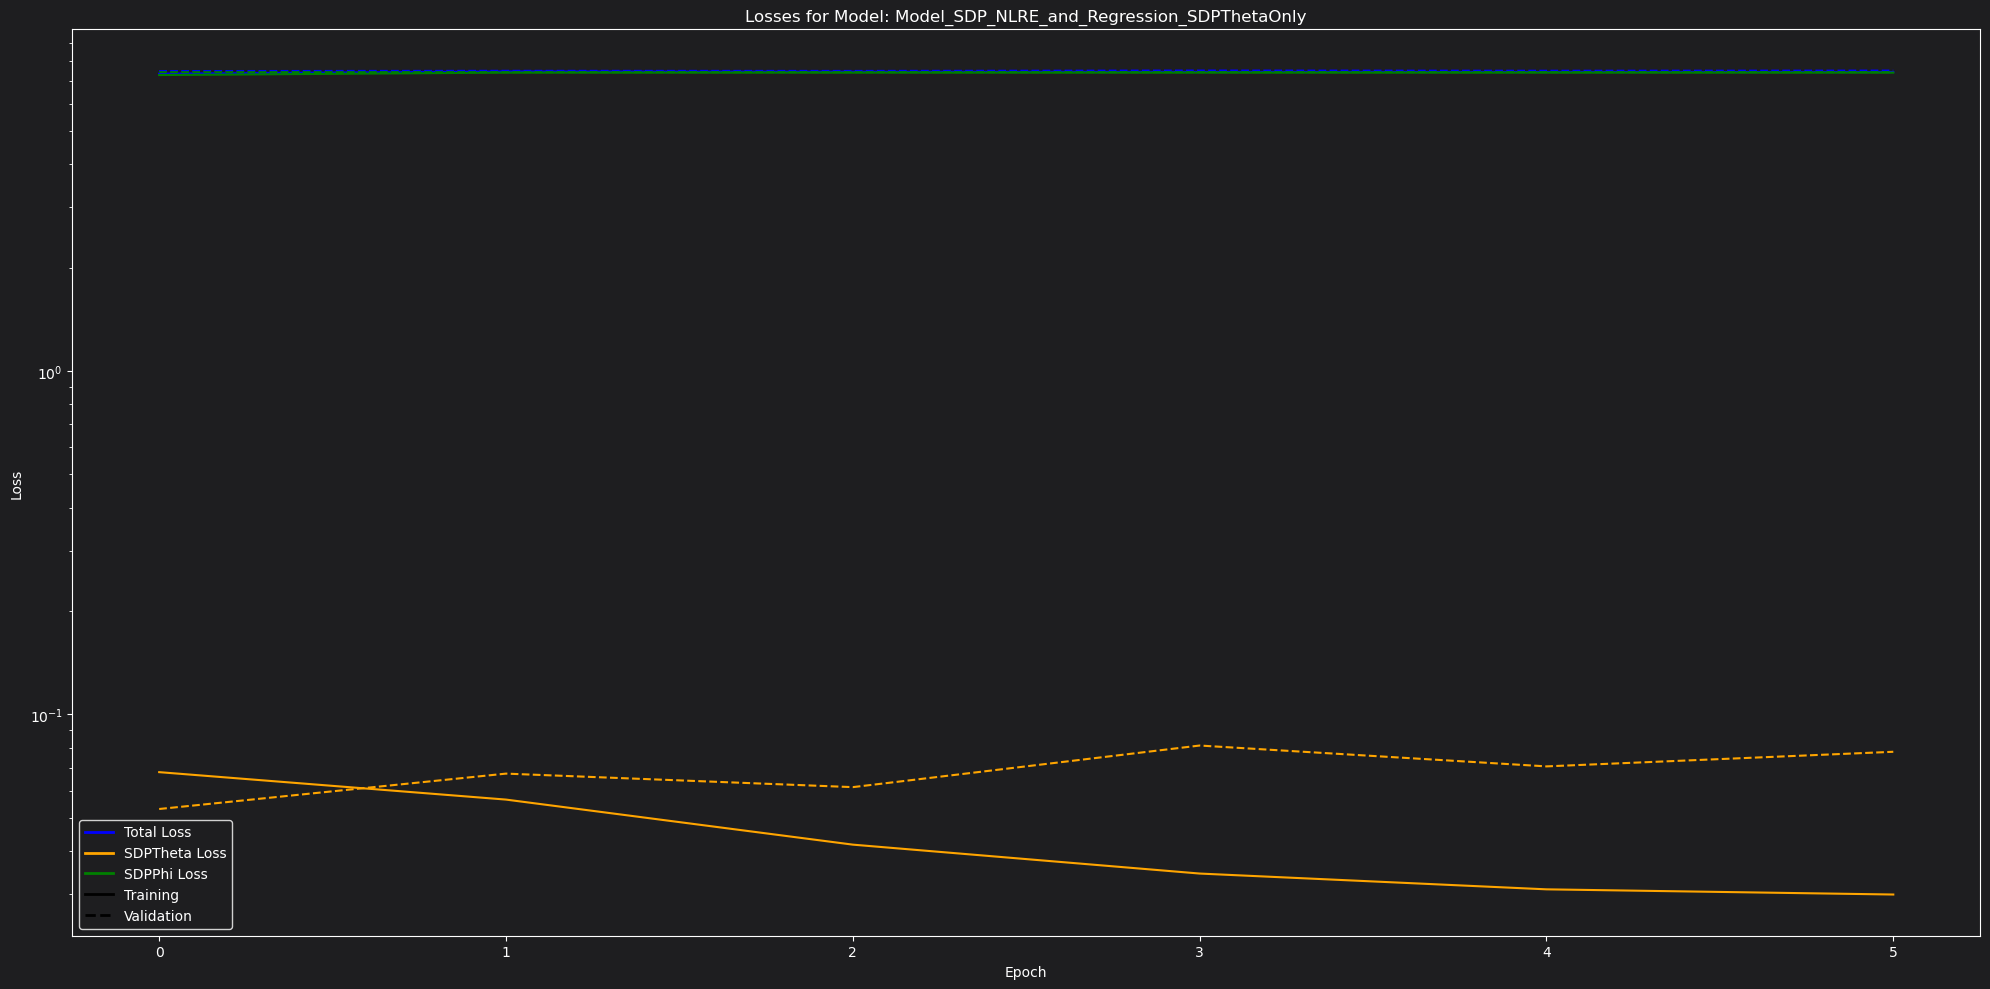

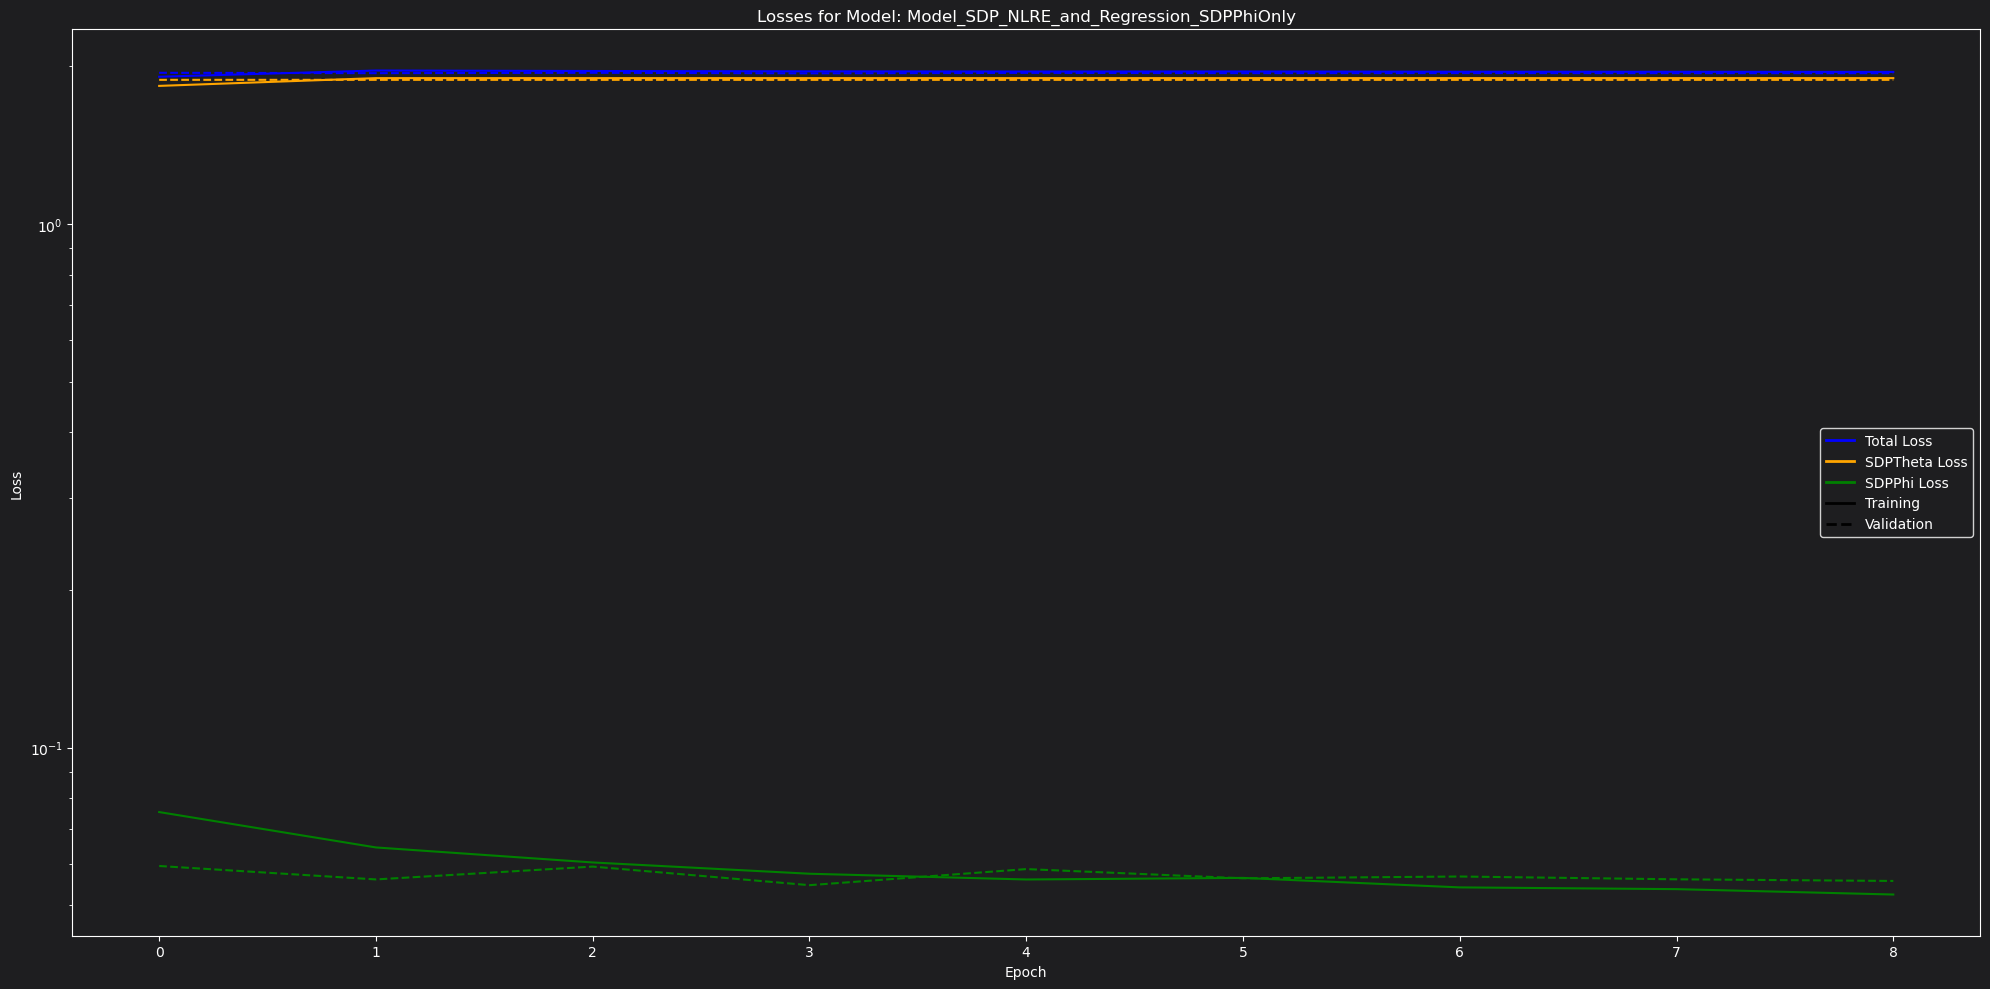

In [9]:
# Loss Plot

for Model_Name,Tracker in zip(Model_Names,Trackers):
    EpochLosses    = Tracker.EpochLoss
    EpochValLosses = Tracker.EpochValLoss
    Keys = list(EpochLosses.keys())
    Nepochs = len(EpochLosses[Keys[0]])

    ax = plt.figure(figsize=(20, 10)).gca()

    # Define colors
    colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


    custom_lines = []
    custom_keys  = []
    for i in range(len(Keys)):
        plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
        plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
        custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
        custom_keys.append(Keys[i]+' Loss')

    custom_lines+= [Line2D([0], [0], color='black', lw=2),
                    Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
    custom_keys += ['Training', 'Validation']


    ax.legend(custom_lines, custom_keys)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
    ax.set_title('Losses for Model: ' + Model_Name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.grid()

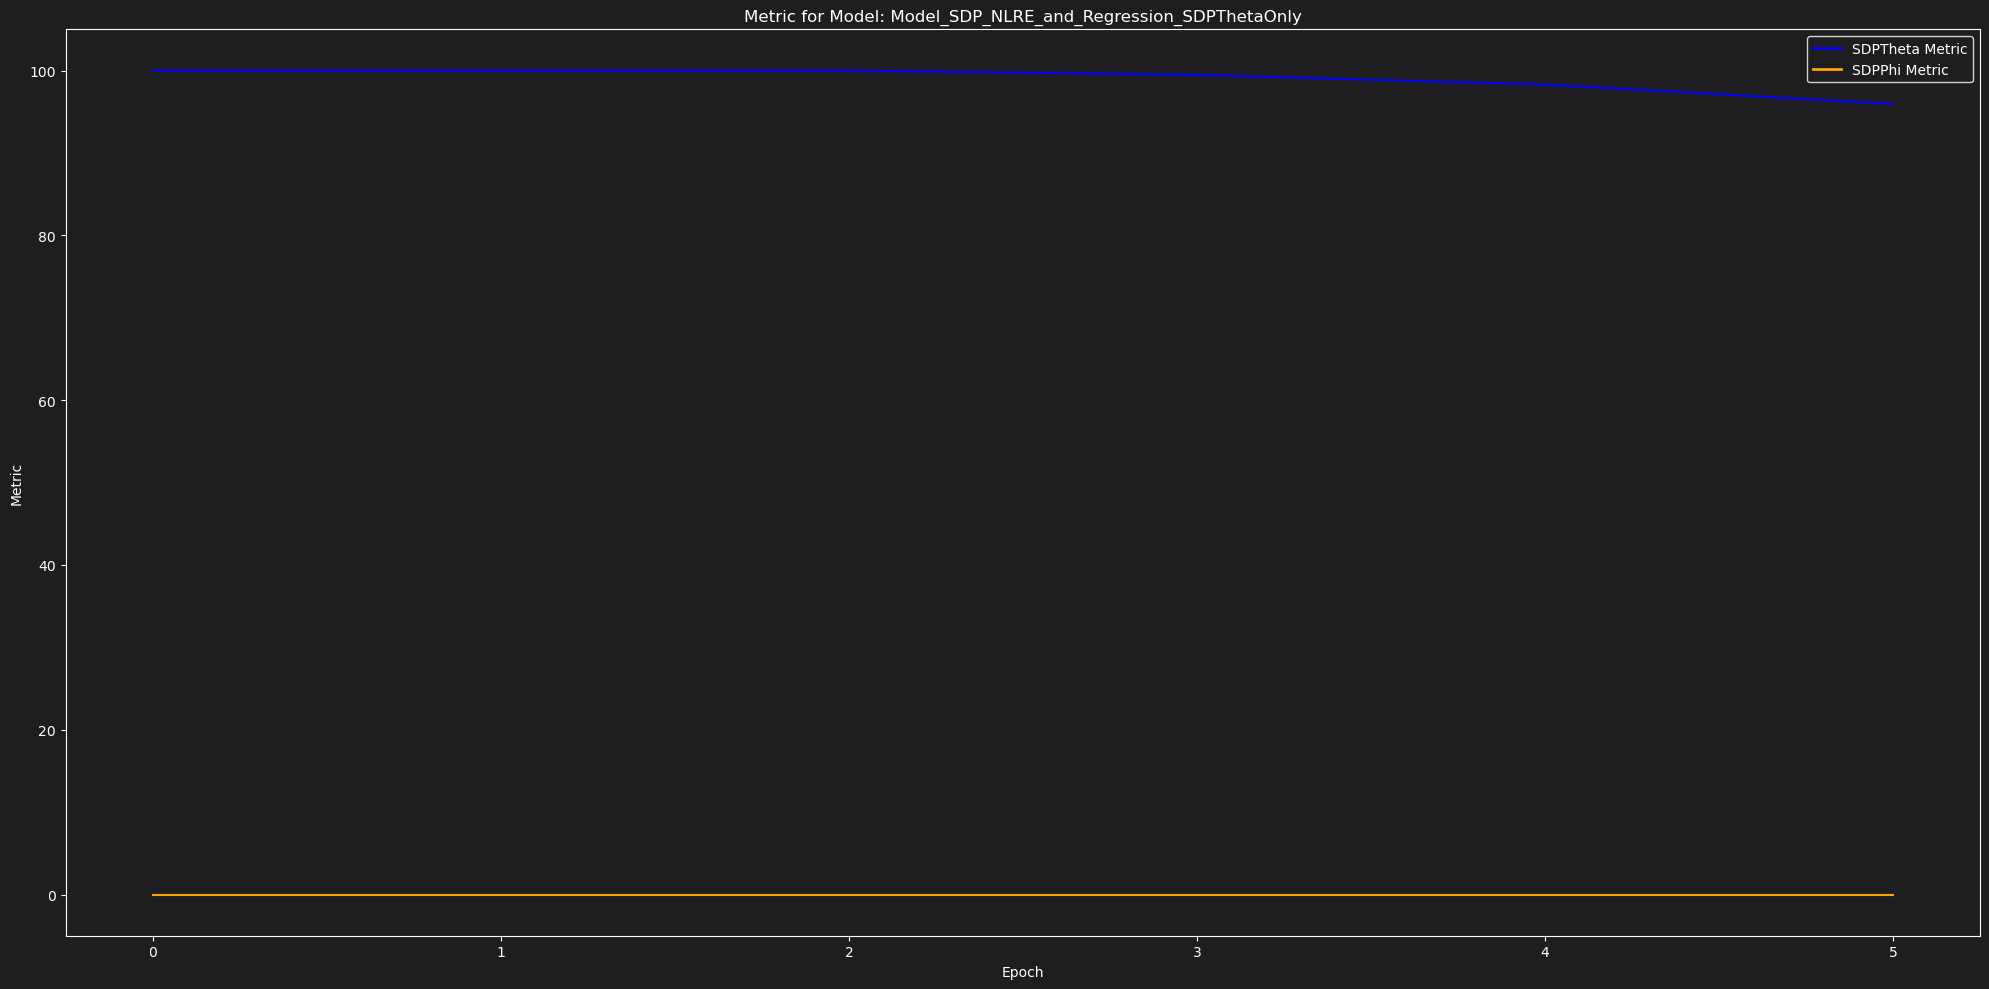

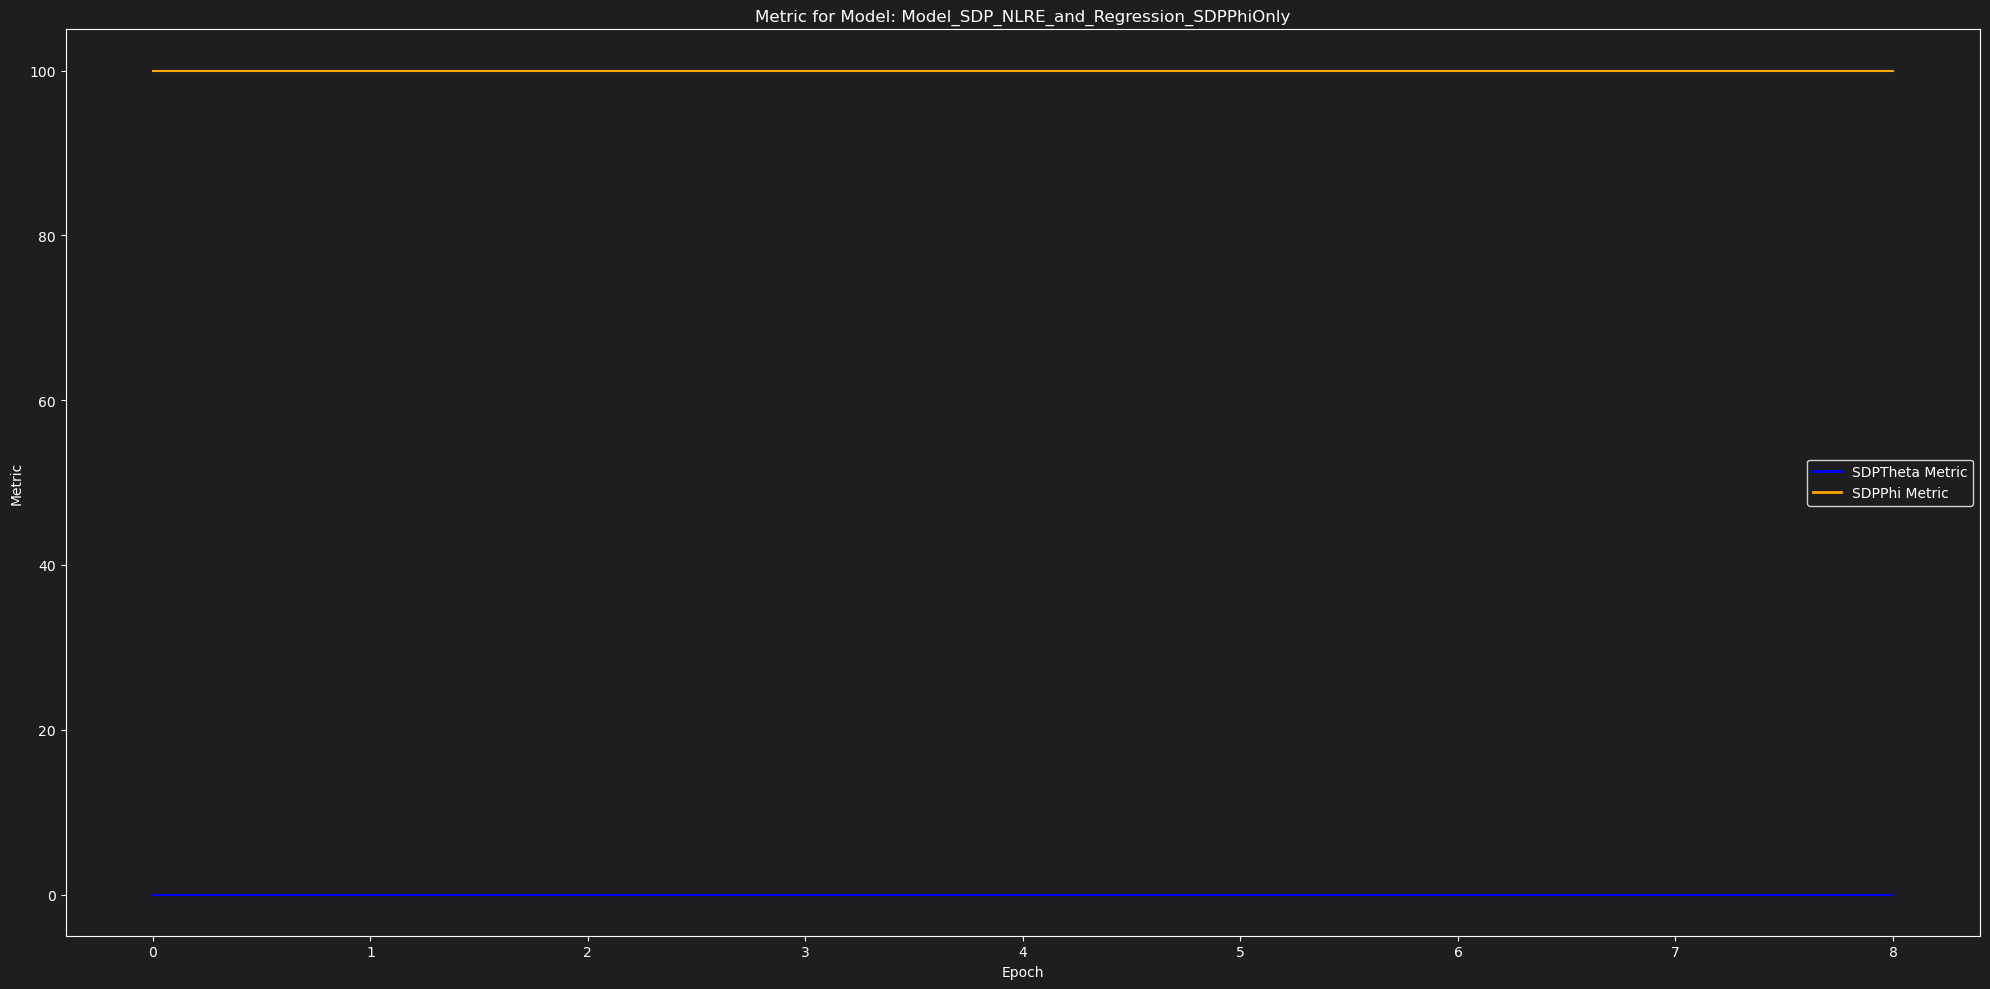

In [10]:
# Metric Plot
for Model_Name,Tracker in zip(Model_Names,Trackers):
    # Loss Plot
    EpochMetrics    = Tracker.EpochMetric
    Keys  = Dataset.Truth_Keys
    Units = Dataset.Truth_Units
    Nepochs = len(EpochLosses[Keys[0]])

    ax = plt.figure(figsize=(20, 10)).gca()

    # Define colors
    colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


    custom_lines = []
    custom_keys  = []
    for i in range(len(Keys)):
        plt.plot(np.array(EpochMetrics[Keys[i]])     , color=colors[i], label=Keys[i] + ' - Metric')
        custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
        custom_keys.append(Keys[i]+' Metric')



    ax.legend(custom_lines, custom_keys)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
    ax.set_title('Metric for Model: ' + Model_Name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric')
    # ax.set_yscale('log')
    ax.grid()

In [11]:
# # Define some metrics - Dont need for the Classification Problem
# def MeanSquaredError(Truths,Predictions):
#     return ((Truths-Predictions)**2).mean()
# def MeanAbsoluteError(Truths,Predictions):
#     return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
# def Percentile68(Truths,Predictions):
#     return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [12]:
# Compute the Test Set

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



for i,Model in enumerate(Models):
    print()
    print(f'Evaluating Model: {Model.Name} ')

    M_Truth   = []
    M_Rec     = []
    M_Reg     = []
    M_Pred    = []
    M_RecVals = []

    Train_Type = None
    Train_Types_Done = []

    Model.to(device)
    torch.cuda.empty_cache()

    Model.eval()
    EvI = 0
    with torch.no_grad():
        for j,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
            
            M_Truth .append(BatchTruth)
            M_Rec   .append(BatchRec)
            
            Model_Out = Model(BatchMains, BatchAux)
            if j == 0: # Check what is the training type
                if   Model_Out[2] is None: Train_Type = 'Classification'
                elif Model_Out[0] is None: Train_Type = 'Regression'
                else:                      Train_Type = 'Both'
                print(f'Detected Training Type : {Train_Type} ')
                Train_Types_Done.append(Train_Type)
            if Train_Type in ['Classification','Both']:
                M_Pred.append(Model_Out[0].cpu())
                M_RecVals.append(Model_Out[1].cpu())
            
            if Train_Type in ['Regression','Both']:
                M_Reg.append(Model_Out[2].cpu())
            
            EvI+=1
            # if EvI == 10: break


    if ('Classification' in Train_Types_Done and 'Regression' in Train_Types_Done) or 'Both' in Train_Types_Done:
        Train_Type = 'Both'
    elif 'Classification' in Train_Types_Done:
        Train_Type = 'Classification'
    elif 'Regression' in Train_Types_Done:
        Train_Type = 'Regression'
    else:
        raise ValueError('No valid Train Type detected from Models!')
    print()
    M_Truth   = torch.cat(M_Truth  , dim=0)
    M_Rec     = torch.cat(M_Rec    , dim=0)
    if Train_Type in ['Classification','Both']:
        M_Pred    = torch.cat(M_Pred   , dim=0)
        M_RecVals = torch.cat(M_RecVals, dim=0)
    if Train_Type in ['Regression','Both']:
        M_Reg     = torch.cat(M_Reg    , dim=0)
    

    M_Reg_Truth = M_Truth.clone() 
    M_Reg_Rec   = M_Rec  .clone()

    if Train_Type in ['Classification','Both']:
        # Augmentation scale
        Augmetation_Scale = M_RecVals.shape[0] // M_Truth.shape[0]
        M_Truth = M_Truth.repeat_interleave(Augmetation_Scale, dim=0)
        M_Rec   = M_Rec  .repeat_interleave(Augmetation_Scale, dim=0)

        M_Truth_labels = (M_RecVals == M_Truth).float()
        M_Pred_labels  = (M_Pred > 0.5 ).float()

    if i==0:
        if Train_Type in ['Classification','Both']:

            Truth        = M_Truth
            Rec          = M_Rec
            Pred         = M_Pred
            RecVals      = M_RecVals

            Truth_labels = M_Truth_labels
            Pred_labels  = M_Pred_labels
        if Train_Type in ['Regression','Both']:
            Reg_Truth = M_Reg_Truth
            Reg_Rec   = M_Reg_Rec
            Reg       = M_Reg

    else:
        if Train_Type in ['Classification','Both']:
            
            Truth[:,i]        = M_Truth[:,i]
            Rec  [:,i]        = M_Rec  [:,i]
            Pred [:,i]        = M_Pred [:,i]
            RecVals[:,i]      = M_RecVals[:,i]
            Truth_labels[:,i] = M_Truth_labels[:,i]
            Pred_labels [:,i] = M_Pred_labels [:,i]
        if Train_Type in ['Regression','Both']:
            Reg_Truth[:,i] = M_Reg_Truth[:,i]
            Reg_Rec  [:,i] = M_Reg_Rec  [:,i]
            Reg      [:,i] = M_Reg[:,i]
        

if Train_Type in ['Classification','Both']:
    Truth   = Truth.numpy()
    Rec     = Rec  .numpy()
    Pred    = Pred .numpy()
    RecVals = RecVals.numpy()

    Truth_labels = Truth_labels.numpy()
    Pred_labels  = Pred_labels.numpy()
if Train_Type in ['Regression','Both']:
    Reg_Truth = Reg_Truth.numpy()
    Reg_Rec   = Reg_Rec  .numpy()
    Reg       = Reg      .numpy()


# Transform Reg Values to angles from sin/cos
if Reg.shape[1] == 4 and Reg_Truth.shape[1] == 2 and 'SDP' in Model.Name:
    print('Transforming Regression Outputs to Angles from Sin/Cosine Representation')
    Reg_Theta = np.arctan2(Reg[:,0], Reg[:,1])
    Reg_Phi   = np.arctan2(Reg[:,2], Reg[:,3])
    Reg = np.stack([Reg_Theta, Reg_Phi], axis=1)

if Train_Type in ['Classification','Both']:
        
    print(Truth.shape)
    print(Pred.shape)

if Train_Type in ['Regression','Both']:
    print(Reg_Truth.shape)
    print(Reg.shape)



Evaluating Model: Model_SDP_NLRE_and_Regression_SDPThetaOnly 
Detected Training Type : Both 


Evaluating Model: Model_SDP_NLRE_and_Regression_SDPPhiOnly 
Detected Training Type : Both 

Transforming Regression Outputs to Angles from Sin/Cosine Representation
(751840, 2)
(751840, 2)
(37592, 2)
(37592, 2)


In [13]:
# Adjust Phi Truth wraparound
if Train_Type in ['Regression','Both']:
    Phi_Truth = Reg_Truth[:,1]
    Phi_Rec   = Reg_Rec  [:,1]
    Phi_Pred  = Reg      [:,1]

    Phi_Truth[Phi_Truth < -np.pi] += 2*np.pi
    Phi_Rec  [Phi_Rec   < -np.pi] += 2*np.pi
    Phi_Pred [Phi_Pred  < -np.pi] += 2*np.pi

    Phi_Truth[Phi_Truth > np.pi] -= 2*np.pi
    Phi_Rec  [Phi_Rec   > np.pi] -= 2*np.pi
    Phi_Pred [Phi_Pred  > np.pi] -= 2*np.pi

    Reg_Truth[:,1] = Phi_Truth
    Reg_Rec  [:,1] = Phi_Rec
    Reg      [:,1] = Phi_Pred


if Train_Type in ['Classification','Both']:
    Phi_Truth = Truth[:,1]
    Phi_Rec   = Rec  [:,1]
    Phi_Pred  = RecVals[:,1]

    Phi_Truth[Phi_Truth < -np.pi] += 2*np.pi
    Phi_Rec  [Phi_Rec   < -np.pi] += 2*np.pi
    Phi_Pred [Phi_Pred  < -np.pi] += 2*np.pi

    Phi_Truth[Phi_Truth > np.pi] -= 2*np.pi
    Phi_Rec  [Phi_Rec   > np.pi] -= 2*np.pi
    Phi_Pred [Phi_Pred  > np.pi] -= 2*np.pi

    Truth[:,1] = Phi_Truth
    Rec  [:,1] = Phi_Rec
    RecVals[:,1] = Phi_Pred
        
        

#### Easy Analysis

In [14]:
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [15]:
# Combined Deviation Plots Function Definition
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)

def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    plt.style.use('default')
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0)  #& (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0)  #& (np.abs(Yp)<20)    & (np.abs(Yr)<20) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)             # & (np.abs(Yp)<3000)    & (np.abs(Yr)<3000)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        # Yp_STD = np.percentile(np.abs(Yp),68)
        # cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        # X  = X [cut]
        # Yp = Yp[cut]
        # Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig

In [16]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

# Metric is Accuracy for classification this time
if Train_Type in ['Classification','Both']:

    for i in range(len(TruthKeys)):
        Key = TruthKeys[i]
        print(f'Truth_labels shape: {Truth_labels.shape} ')
        print(f'Pred_labels  shape: {Pred_labels.shape} ')

        Accuracy = (Truth_labels[:,i] == Pred_labels[:,i]).mean()
        print(f'Accuracy for {Key:15s} : {Accuracy*100:6.2f} %')

if Train_Type in ['Regression','Both']:
    
    for i in range(len(TruthKeys)):
        Key  = TruthKeys [i]
        Unit = TruthUnits[i]

        percentile = Percentile68(Reg_Truth[:,i], Reg[:,i])
        if Unit == 'rad':
            percentile *= (180/np.pi)
            Unit = 'deg'
        print(f'Percentile 68 for {Key:15s} : {percentile:6.2f} {Unit}')
            

Truth_labels shape: (751840, 2) 
Pred_labels  shape: (751840, 2) 
Accuracy for SDPTheta        :  95.95 %
Truth_labels shape: (751840, 2) 
Pred_labels  shape: (751840, 2) 
Accuracy for SDPPhi          : 100.00 %
Percentile 68 for SDPTheta        :  36.66 deg
Percentile 68 for SDPPhi          : 232.25 deg


In [17]:
# Classification Positive Percentages
if Train_Type in ['Classification','Both']:
    print(f'Truth Labels Positive percentage = {Truth_labels.mean(axis=0)*100}')
    print(f'Pred  Labels Positive percentage = {Pred_labels.mean(axis=0)*100}')
else:
    print('No Classification Outputs to show Positive Percentages for.')

Truth Labels Positive percentage = [0. 0.]
Pred  Labels Positive percentage = [4.0487337 0.       ]


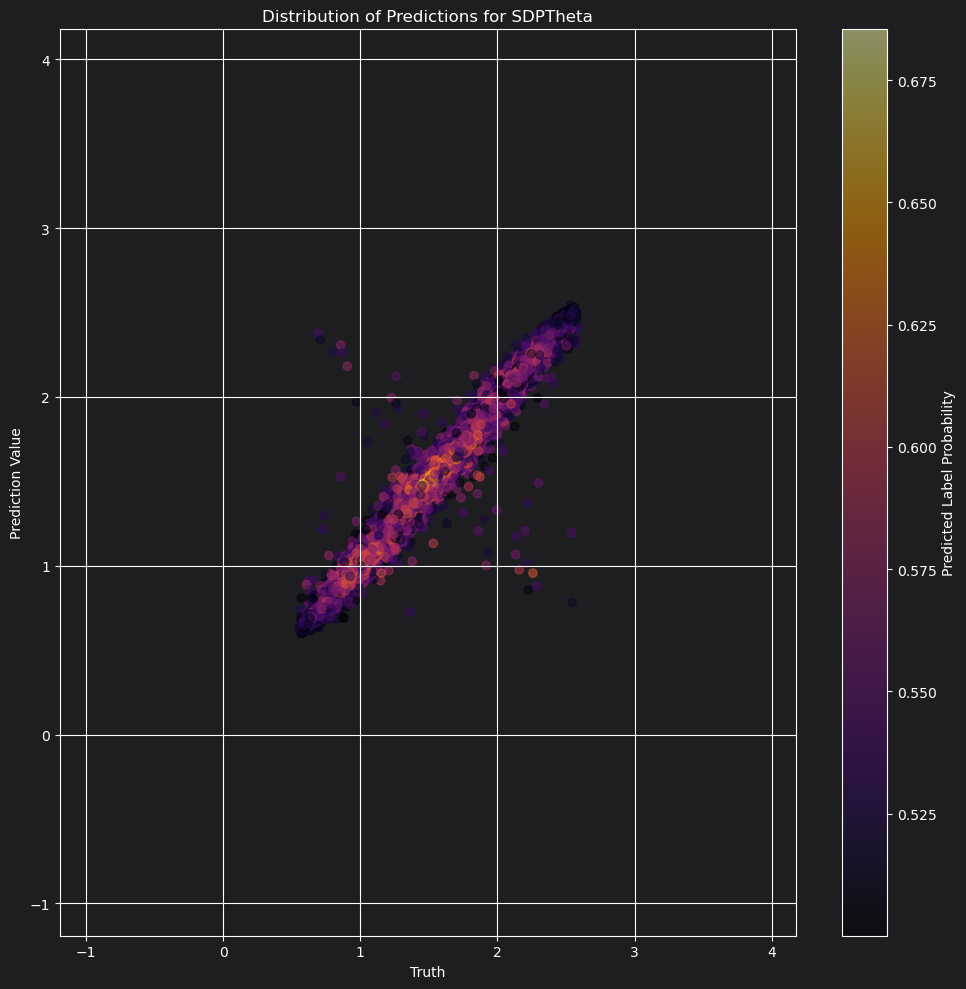

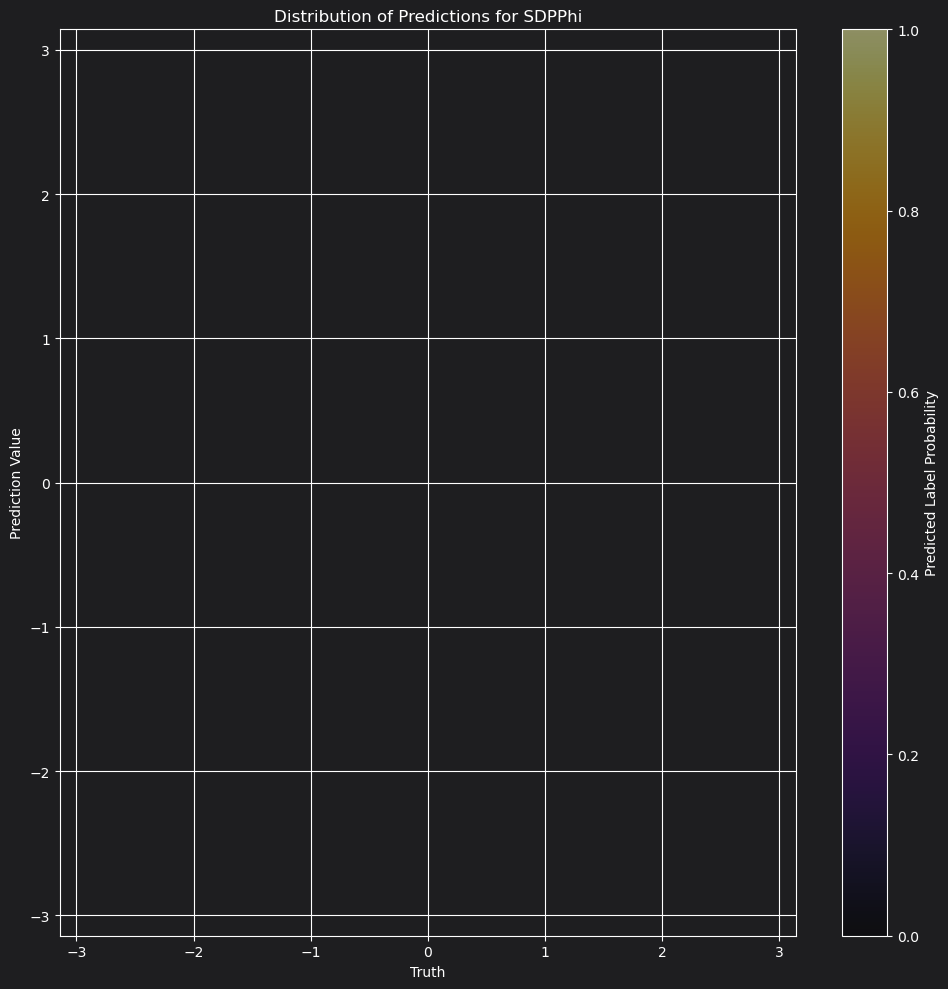

In [18]:
# Classification Prediction Distributions Plots
if Train_Type not in ['Classification','Both']:
    print('No Classification Outputs to show Prediction Distributions for.')
else:
    for i, key in enumerate(TruthKeys):
        
        plt.figure(figsize=(10,10))
        plt.title(f'Distribution of Predictions for {key}')
        Threshold = 0.5
        Mask = Pred[:,i]>=Threshold

        # plt.scatter(Truth[::,i], RecVals[::,i], alpha=0.1,c = Pred[:,i], cmap='inferno')
        # plt.scatter(Truth[::,i], RecVals[::,i], alpha=1,c = Pred[:,i], cmap='inferno')
        plt.scatter(Truth[Mask,i], RecVals[Mask,i], alpha=0.5,c = Pred[Mask,i], cmap='inferno', label='Predicted Positive')
        plt.xlabel('Truth')
        plt.ylabel('Prediction Value')
        # Set Equal Limits
        min_val = min(Truth[:,i].min(), RecVals[:,i].min())
        max_val = max(Truth[:,i].max(), RecVals[:,i].max())
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.colorbar(label='Predicted Label Probability',alpha=1.0)
        plt.show()
        

Plotting for SDPTheta
Plotting for SDPPhi


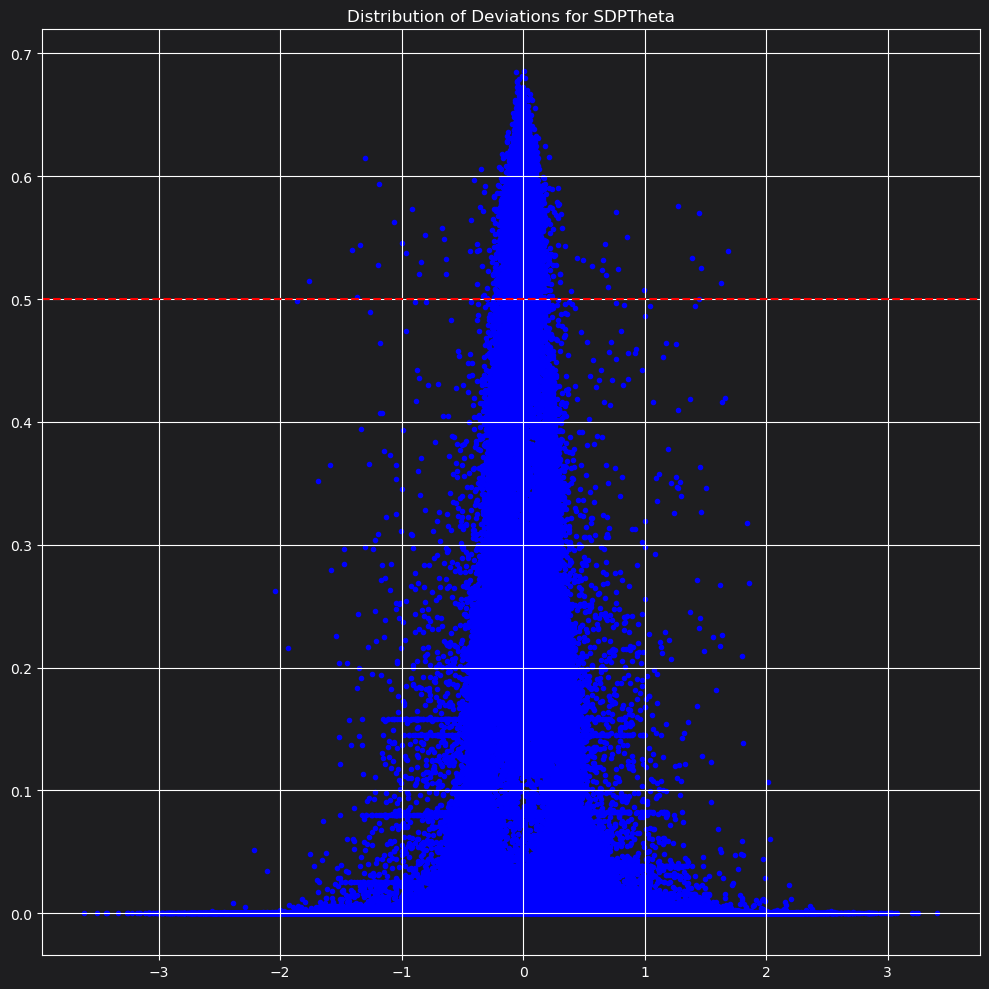

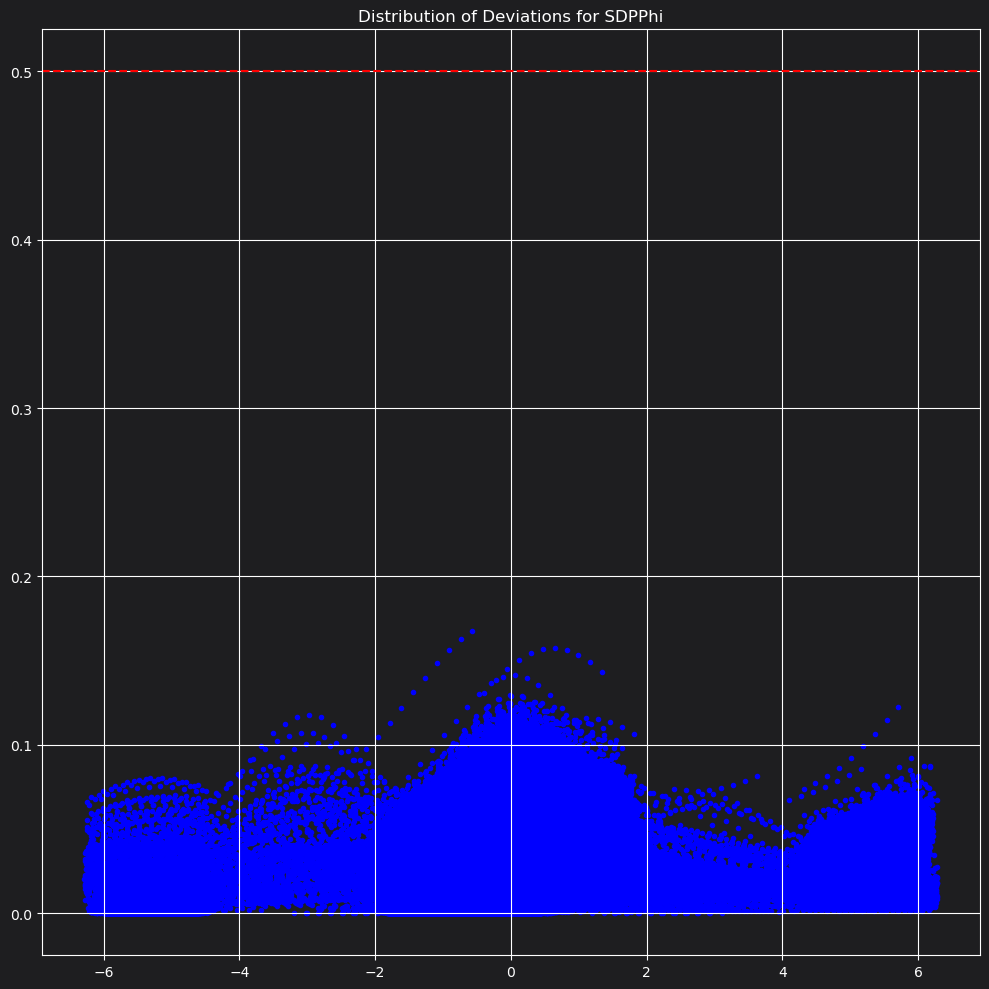

In [19]:
# Classification Deviation Distributions Plots
if Train_Type not in ['Classification','Both']:
    print('No Classification Outputs to show Deviation Distributions for.')
else:
    for i,key in enumerate(TruthKeys):
        print(f'Plotting for {key}')

        Deviations = RecVals[:,i] - Truth[:,i]

        plt.figure(figsize=(10,10))
        plt.title(f'Distribution of Deviations for {key}')

        plt.scatter(Deviations,Pred[:,i], alpha=1,c = 'blue',marker='.')    
        plt.axhline(0.5, color='red', linestyle='dashed', label='Decision Boundary')

Total Points before cuts 37592
SDPTheta Total Points after cuts 37592
SDPPhi Total Points after cuts 37592


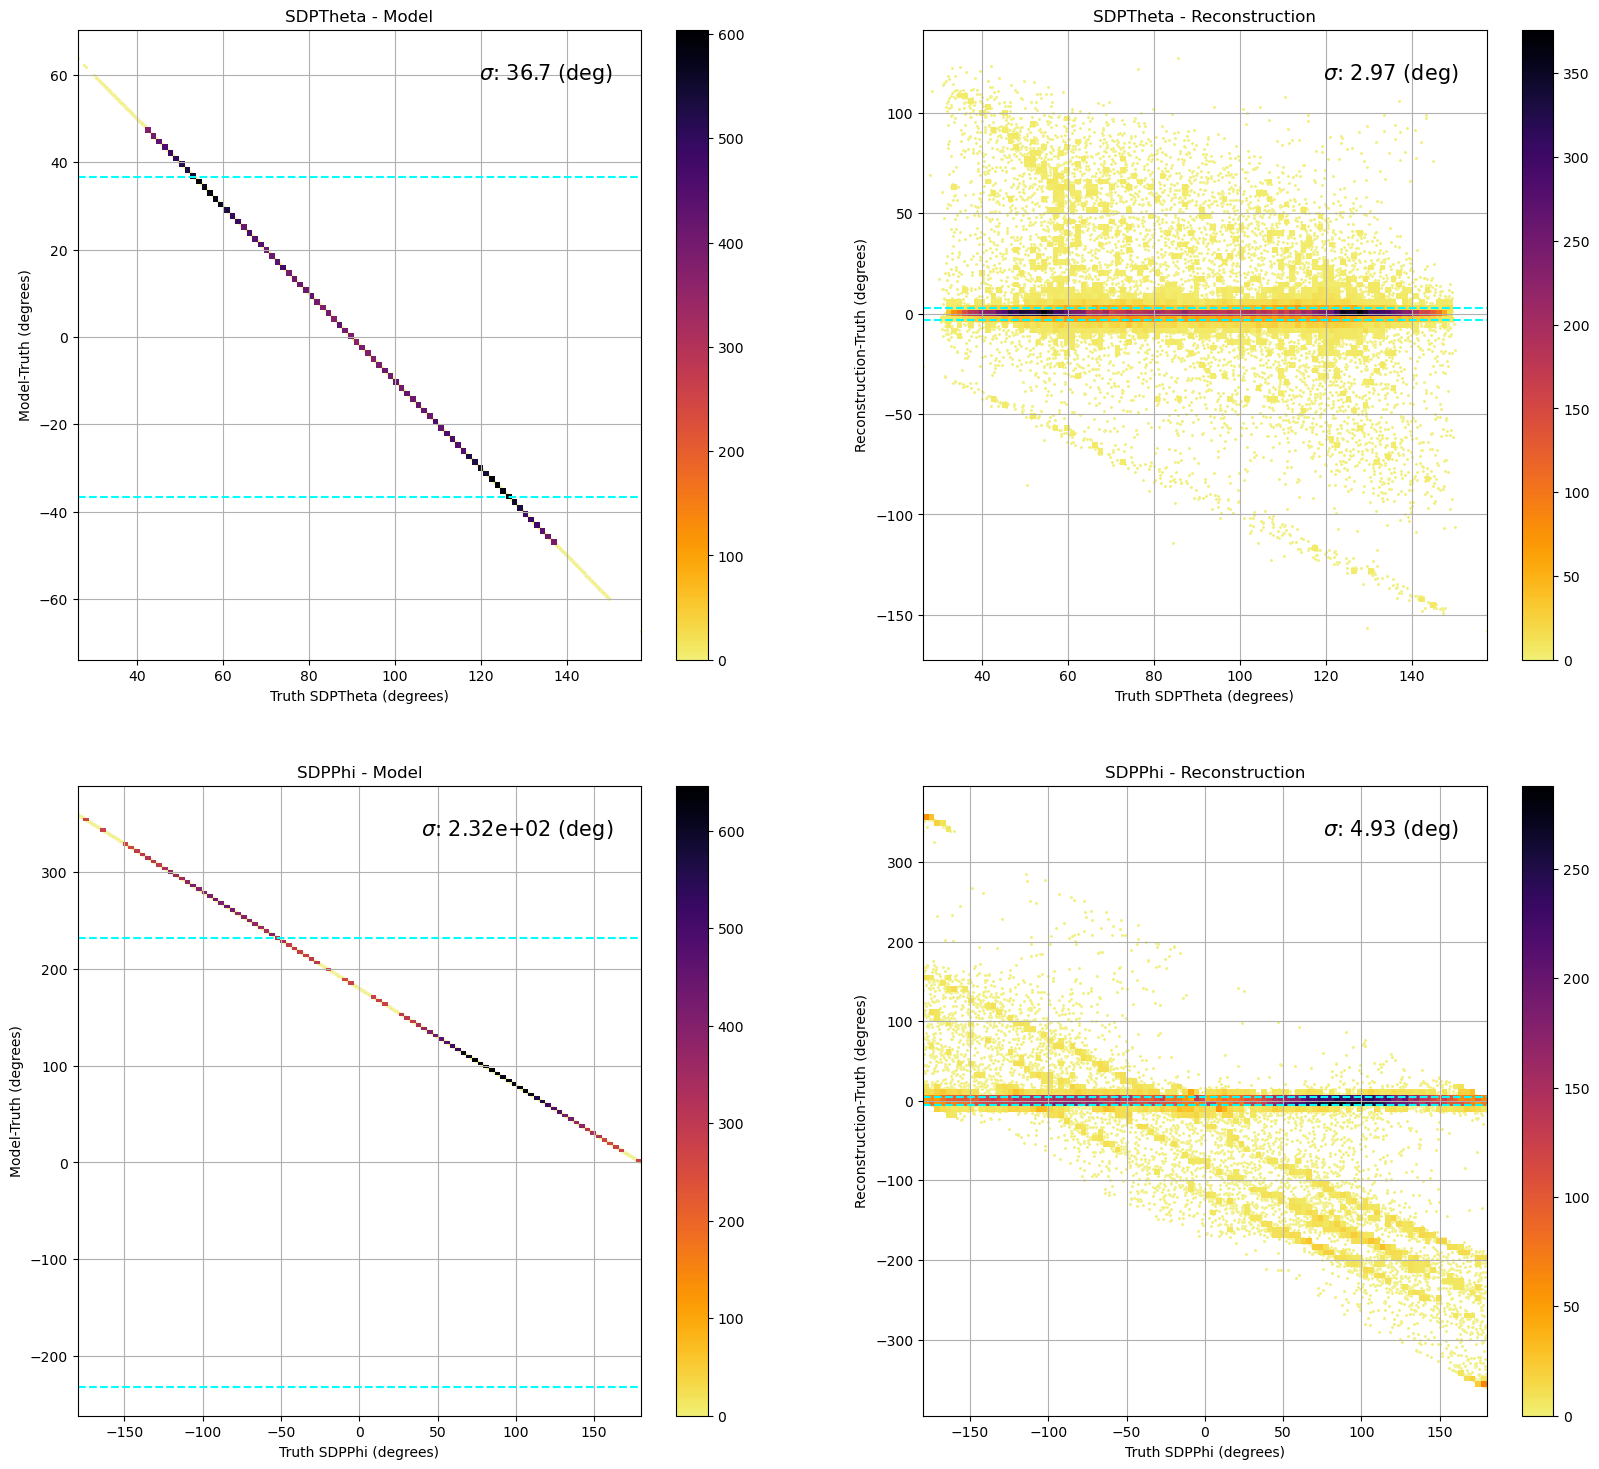

In [20]:
# Combined deviation plot for Regression 
if Train_Type not in ['Regression','Both']:
    print('No Regression Outputs to show Regression Distributions for.')

else:
    TruthKeys_Reg  = Dataset.Truth_Keys
    TruthUnits_Reg = Dataset.Truth_Units
    fig = CombinedDeviationPlots(TruthKeys_Reg,TruthUnits_Reg,Reg_Truth,Reg,Reg_Rec)
    

#### Variational Method on 1 event


In [21]:
import pandas as pd
AllPossiblePixelDirections = pd.read_csv('../../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


In [22]:
# Select a telescope Skeleton
TelescopeID = 3
EyeID       = 5
TelescopePixels = AllPossiblePixelDirections[ (AllPossiblePixelDirections['TelID'] == TelescopeID) & (AllPossiblePixelDirections['EyeID'] == EyeID) ]

def XYToIndex(Xs, Ys, return_tensor=False):
    """
    Convert X, Y coordinates back to pixel indices.
    Inverse of IndexToXY function.
    
    Parameters:
    -----------
    Xs : torch.Tensor or list
        X coordinates (row indices)
    Ys : torch.Tensor or list
        Y coordinates (column indices)
    return_tensor : bool
        If True, return as tensor; if False, return as list
    
    Returns:
    --------
    indices : torch.Tensor or list
        Pixel indices (1-indexed)
    """
    # Convert to tensors if needed
    if not isinstance(Xs, torch.Tensor):
        Xs = torch.tensor(Xs)
    if not isinstance(Ys, torch.Tensor):
        Ys = torch.tensor(Ys)
    
    # Reverse the operation: indices = Xs * 22 + Ys + 1
    indices = Xs * 22 + Ys + 1
    
    if return_tensor:
        return indices.int()
    else:
        return indices.int().tolist()

In [23]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}
print(Dataset.Aux_Keys)

('Gen_LogE', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp', 'Gen_SDPTheta', 'Gen_SDPPhi', 'Gen_EventClass', 'Gen_Primary', 'Gen_CosZenith', 'Gen_CherenkovFraction')


#### Finding out the uncertainty and using variations as measure

In [24]:
# print(f'Testing Variations Computation')
# # Variations Computation
# for j in range(1):
#     # Pick a random event
#     Dataset.State = 'Test'
#     Dataset.BatchSize = 1
#     N = np.random.randint(len(Dataset))
#     # N = 16
#     # N= 22464
#     print(f'N = {N}')

#     for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
#         if i == N:break
#         else: continue
#     Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
#     RecVals = BatchMains[1] if BatchMains[0].ndim == 4 else BatchMains[0]

    

#     Event_Class = BatchAux[0,Dataset.Aux_Keys.index('Gen_EventClass')]
#     Event_Class_Name = event_class_labels.get(Event_Class.int().item(), 'Unknown')

    

#     if True: # Event plot
#         print(f'Inspecting Event {EventIndex.int().item()}')

#         # print('Ground Truth:')
#         This_Truth = f'True Values:\n'
#         for k,key in enumerate(Dataset.Truth_Keys):
#             if Dataset.Truth_Units[k] == 'rad':
#                 This_Truth += f'  {key:15s} : {np.degrees(BatchTruth[0,k].item()):.2f} deg\n'
#                 # print(This_Truth)
#             else:
#                 This_Truth += f'  {key:15s} : {BatchTruth[0,k].item():.4f} {Dataset.Truth_Units[k]}\n'
#             # print(This_Truth)

#         XYs = torch.nonzero(Main[0,0]>0.0, as_tuple=False)
#         Pixel_Indices = XYToIndex(XYs[:,0], XYs[:,1], return_tensor=False)

#         Charges = Main[0,0, XYs[:,0], XYs[:,1]].cpu().numpy()
#         Times   = Main[0,1, XYs[:,0], XYs[:,1]].cpu().numpy()
        
#         # Unnormalise for plots
#         # assuming original normalisation was log10(torch.clamp_min(Charge,0)+1)/3.75
#         Charges = 10**(Charges*3.75)-1
#         Times   = Times*40

#         Phis   = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Phi'  ].values
#         Thetas = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Theta'].values

#         fig, ax = plt.subplots(figsize=(6, 4))
#         root_scale = 0.7
#         # Main scatter
#         scatter = ax.scatter(Phis, Thetas, s=Charges**root_scale, c=Times, cmap='inferno', 
#                             edgecolors='black', linewidths=0.5)

#         # Background pixels
#         ax.scatter(TelescopePixels['Phi'], TelescopePixels['Theta'], 
#                 c='gray', s=5, alpha=0.3, zorder=0)

#         # Size legend
#         charge_percentiles = np.percentile(Charges, [25, 50, 75, 100])
#         for i, pct in enumerate([25, 50, 75, 100]):
#             charge_val = np.percentile(Charges, pct)
#             size_val = charge_val**root_scale
#             ax.scatter([], [], s=size_val, c='gray', alpha=0.6, 
#                     label=f'{pct}th %: {charge_val:.0f}')

#         ax.legend(title='Charge', loc='upper left', framealpha=0.9)
#         plt.colorbar(scatter, label='Time [Bins?]', ax=ax)
#         ax.set_xlabel('Phi [rad]')
#         ax.set_ylabel('Theta [rad]')
#         ax.set_title(f'Event {EventIndex.int().item()}: Pixel Charges and Times, Class {Event_Class_Name}')
#         ax.grid(False)
#         ax.invert_xaxis()

#         ax.text(0.35, 0.75, This_Truth, transform=ax.transAxes, fontsize=10)



#     if True: # Variation plot
#         assert Models_are_Independent, "This method assumes models are independent"
#         assert 'SDPTheta' in Dataset.Truth_Keys[0] and 'SDPTheta' in Model_Names[0], "This method assumes first truth key is SDPTheta"
#         assert 'SDPPhi'   in Dataset.Truth_Keys[1] and 'SDPPhi'   in Model_Names[1], "This method assumes second truth key is SDPPhi"


#         Variation_Scale = 180
#         Variation_Steps = 0.25
        
        
        
#         N_Variations = int(Variation_Scale//Variation_Steps + 1)
#         Variation_Scale *= np.pi/180
        
#         Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations) 
            

#         Test_Main = Main.repeat(N_Variations,1,1,1)
        
#         Theta_Model = Models[0]
#         Phi_Model   = Models[1]

#         Theta_Model.to(device)
#         Phi_Model  .to(device)

#         Theta_Model.eval()
#         Phi_Model  .eval()

#         torch.cuda.empty_cache()

#         with torch.no_grad():
#             Test_Thetas = Variations
#             Test_Phis   = Variations

#             Model_in = (Test_Main,torch.stack([Test_Thetas,Test_Phis],dim=1).to(device))
            
#             Model_Out_Theta = Theta_Model(Model_in,Aux = None, Augmentation_Scale = 1,Augmentation_Function = 'NoAugmentation')
#             Model_Out_Phi   = Phi_Model  (Model_in,Aux = None, Augmentation_Scale = 1)

#             Preds_Theta = Model_Out_Theta[0].cpu().numpy()[:,0]
#             Preds_Phi   = Model_Out_Phi  [0].cpu().numpy()[:,1]
#             Test_Thetas = Test_Thetas.numpy()
#             Test_Phis   = Test_Phis  .numpy()
            
#             # Update best guesses
#             Best_Theta_Idx = np.argmax(Preds_Theta)
#             Best_Phi_Idx   = np.argmax(Preds_Phi  )
            
    
#         fig, ax = plt.subplots(1,2, figsize=(20,9))
#         ax[0].plot(np.rad2deg(Test_Thetas), Preds_Theta, marker='', linestyle='-', alpha=0.7)
#         ax[1].plot(np.rad2deg(Test_Phis  ), Preds_Phi  , marker='', linestyle='-', alpha=0.7)

#         for i,key in enumerate(Dataset.Truth_Keys):
#             ax[i].set_title(f'{key} Variations likelihood')
#             ax[i].set_xlabel(f'{key} Variation (deg)')
#             ax[i].set_ylabel('Predicted Label Probability')

#             Estimated_max = Test_Thetas[Best_Theta_Idx] if i==0 else Test_Phis[Best_Phi_Idx]
            
#             # Values
#             True_Value    = np.rad2deg(BatchTruth[0,i].item())
#             Rec_Value     = np.rad2deg(BatchRec[0,i]  .item())
#             Pred_Value    = np.rad2deg(Estimated_max)
            
#             if True_Value < -180: True_Value += 360
#             if Rec_Value  < -180: Rec_Value  += 360
            
#             # Round them for print
#             True_Value_r  = np.round(True_Value, 2)
#             Rec_Value_r   = np.round(Rec_Value , 2)
#             Pred_Value_r  = np.round(Pred_Value, 2)

#             ax[i].axvline(True_Value , color='green' , linestyle=':' , label=f'True Value                 : {True_Value_r} deg')
#             ax[i].axvline(Rec_Value  , color='orange', linestyle='-.', label=f'Reconstructed Value : {Rec_Value_r } deg')
#             ax[i].axvline(Pred_Value , color='blue'  , linestyle='--', label=f'Estimated Max L       : {Pred_Value_r} deg')

            
#             ax[i].legend()
#             ax[i].grid(False)
#             ax[i].set_ylim(0, 1)
#             ax[i].grid(True)

#             if key == 'SDPTheta': ax[i].set_xlim(0,180)
#             elif key == 'SDPPhi': ax[i].set_xlim(-180,180)
#             # Find Peaks
#             distance = 10 # deg
#             distance = distance / Variation_Steps  # in steps
            
#             peaks, properties = find_peaks(Preds_Theta if i==0 else Preds_Phi, distance = distance, height = 0.5)
#             widths, width_heights, left_ips, right_ips = peak_widths(Preds_Theta if i==0 else Preds_Phi, peaks, rel_height=1/np.sqrt(2))

#             print(f'Found peaks at indices: {np.rad2deg(Test_Thetas[peaks]) if i==0 else np.rad2deg(Test_Phis[peaks])} with widths: {widths*Variation_Steps} deg, with heights: {properties["peak_heights"]}')
    
            

Testing Variations Computation
N = 3386
Inspecting Event 811404608
Test Thetas : [-48.24912  -38.249123 -28.249119 ... 121.75088  131.75087  141.75087 ]
Test Phis   : [ 50.519688  60.519688  70.51969  ... 220.51968  230.51968  240.51968 ]
Reg Theta   : 51.75087356567383
Reg Phi     : 150.51968383789062
Found peaks at indices: [51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874 51.750874
 51.750874 51.750874 51.750874 51

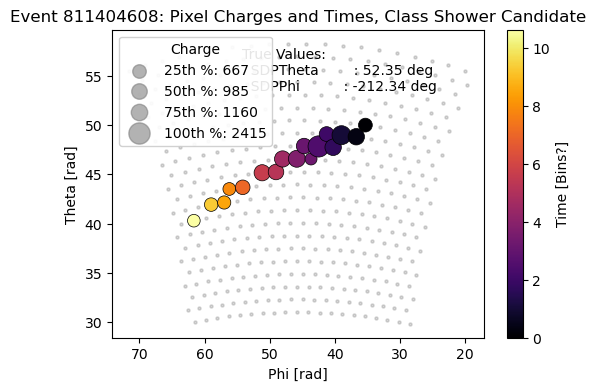

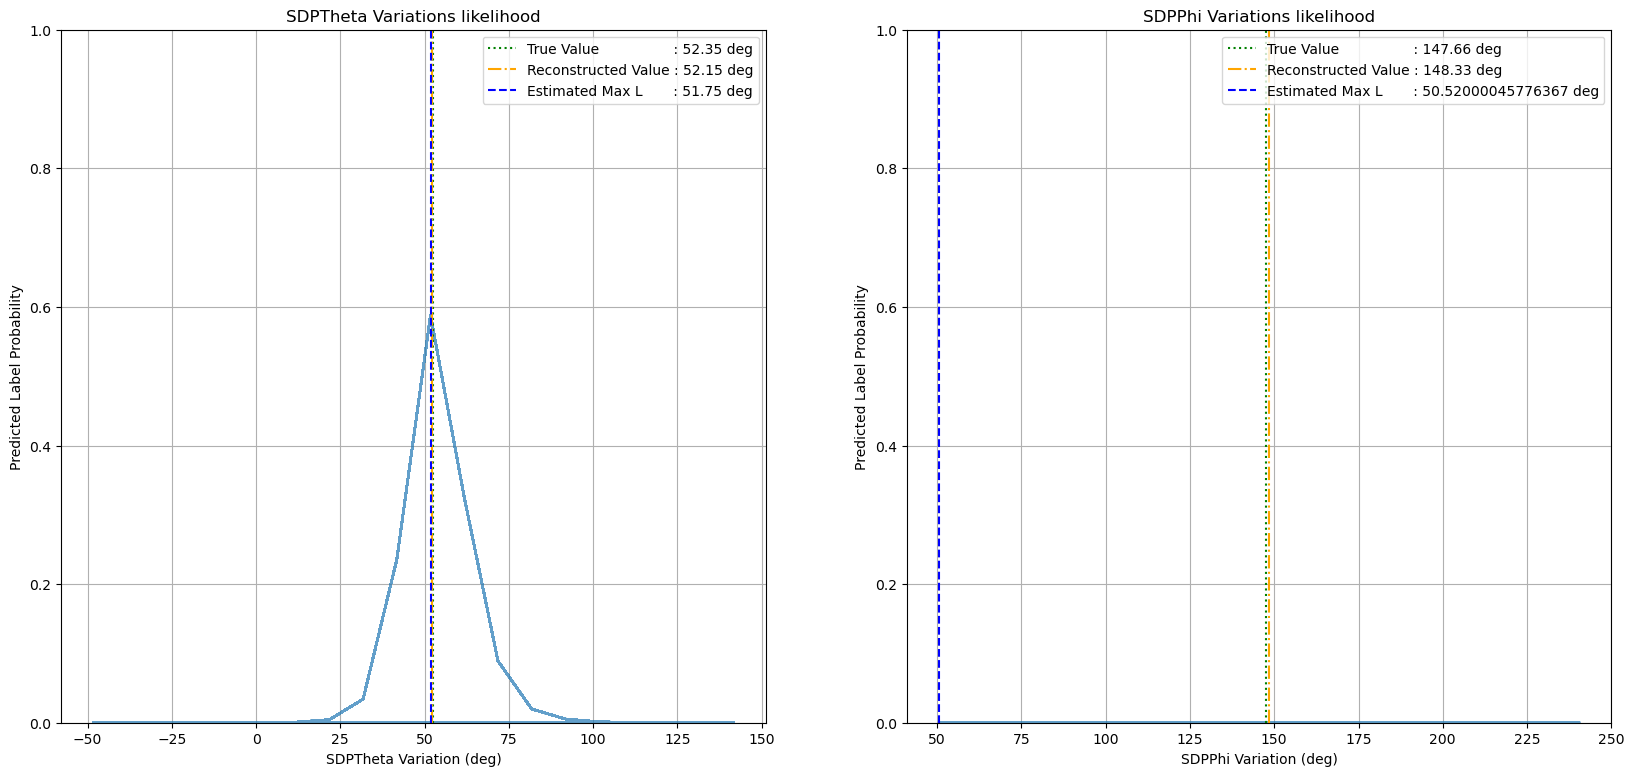

In [33]:
print(f'Testing Variations Computation')
# Variations Computation
for j in range(1):
    # Pick a random event
    Dataset.State = 'Test'
    Dataset.BatchSize = 1
    N = np.random.randint(len(Dataset))
    # N = 16
    # N= 22464
    print(f'N = {N}')

    for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
        if i == N:break
        else: continue
    Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
    RecVals = BatchMains[1] if BatchMains[0].ndim == 4 else BatchMains[0]

    

    Event_Class = BatchAux[0,Dataset.Aux_Keys.index('Gen_EventClass')]
    Event_Class_Name = event_class_labels.get(Event_Class.int().item(), 'Unknown')

    

    if True: # Event plot
        print(f'Inspecting Event {EventIndex.int().item()}')

        # print('Ground Truth:')
        This_Truth = f'True Values:\n'
        for k,key in enumerate(Dataset.Truth_Keys):
            if Dataset.Truth_Units[k] == 'rad':
                This_Truth += f'  {key:15s} : {np.degrees(BatchTruth[0,k].item()):.2f} deg\n'
                # print(This_Truth)
            else:
                This_Truth += f'  {key:15s} : {BatchTruth[0,k].item():.4f} {Dataset.Truth_Units[k]}\n'
            # print(This_Truth)

        XYs = torch.nonzero(Main[0,0]>0.0, as_tuple=False)
        Pixel_Indices = XYToIndex(XYs[:,0], XYs[:,1], return_tensor=False)

        Charges = Main[0,0, XYs[:,0], XYs[:,1]].cpu().numpy()
        Times   = Main[0,1, XYs[:,0], XYs[:,1]].cpu().numpy()
        
        # Unnormalise for plots
        # assuming original normalisation was log10(torch.clamp_min(Charge,0)+1)/3.75
        Charges = 10**(Charges*3.75)-1
        Times   = Times*40

        Phis   = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Phi'  ].values
        Thetas = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Theta'].values

        fig, ax = plt.subplots(figsize=(6, 4))
        root_scale = 0.7
        # Main scatter
        scatter = ax.scatter(Phis, Thetas, s=Charges**root_scale, c=Times, cmap='inferno', 
                            edgecolors='black', linewidths=0.5)

        # Background pixels
        ax.scatter(TelescopePixels['Phi'], TelescopePixels['Theta'], 
                c='gray', s=5, alpha=0.3, zorder=0)

        # Size legend
        charge_percentiles = np.percentile(Charges, [25, 50, 75, 100])
        for i, pct in enumerate([25, 50, 75, 100]):
            charge_val = np.percentile(Charges, pct)
            size_val = charge_val**root_scale
            ax.scatter([], [], s=size_val, c='gray', alpha=0.6, 
                    label=f'{pct}th %: {charge_val:.0f}')

        ax.legend(title='Charge', loc='upper left', framealpha=0.9)
        plt.colorbar(scatter, label='Time [Bins?]', ax=ax)
        ax.set_xlabel('Phi [rad]')
        ax.set_ylabel('Theta [rad]')
        ax.set_title(f'Event {EventIndex.int().item()}: Pixel Charges and Times, Class {Event_Class_Name}')
        ax.grid(False)
        ax.invert_xaxis()

        ax.text(0.35, 0.75, This_Truth, transform=ax.transAxes, fontsize=10)



    if True: # Variation plot
        assert Models_are_Independent, "This method assumes models are independent"
        assert 'SDPTheta' in Dataset.Truth_Keys[0] and 'SDPTheta' in Model_Names[0], "This method assumes first truth key is SDPTheta"
        assert 'SDPPhi'   in Dataset.Truth_Keys[1] and 'SDPPhi'   in Model_Names[1], "This method assumes second truth key is SDPPhi"


        Variation_Scale = 180
        Variation_Steps = 0.25
        
        
        
        N_Variations = int(Variation_Scale//Variation_Steps + 1)
        Variation_Scale *= np.pi/180
        
        Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations) 
            

        Test_Main = Main.repeat(N_Variations,1,1,1)
        
        Theta_Model = Models[0]
        Phi_Model   = Models[1]

        Theta_Model.to(device)
        Phi_Model  .to(device)

        Theta_Model.eval()
        Phi_Model  .eval()

        torch.cuda.empty_cache()

        with torch.no_grad():
            # Test_Thetas = Variations
            # Test_Phis   = Variations
            Test_Thetas = torch.tensor([1])
            Test_Phis   = torch.tensor([1])
            Model_in = (Test_Main,torch.stack([Test_Thetas,Test_Phis],dim=1).to(device))
            
            Model_Out_Theta = Theta_Model(Model_in,Aux = None, Augmentation_Scale = 10,Augmentation_Function = 'UniformNearSample')
            Model_Out_Phi   = Phi_Model  (Model_in,Aux = None, Augmentation_Scale = 10,Augmentation_Function = 'UniformNearSample')

            Preds_Theta = Model_Out_Theta[0].cpu().numpy()[:,0]
            Preds_Phi   = Model_Out_Phi  [0].cpu().numpy()[:,1]
            Test_Thetas = Model_Out_Theta[1].cpu().numpy()[:,0]
            Test_Phis   = Model_Out_Phi  [1].cpu().numpy()[:,1]
            
            Reg_Theta   = Model_Out_Theta[2].cpu().numpy()[:,0:2]
            Reg_Phi     = Model_Out_Phi  [2].cpu().numpy()[:,2:4]

            Reg_Theta = np.arctan2(Reg_Theta[:,0], Reg_Theta[:,1])
            Reg_Phi   = np.arctan2(Reg_Phi  [:,0], Reg_Phi  [:,1])


            # print(f'Preds_Theta: {Preds_Theta}')
            print(f'Test Thetas : {np.rad2deg(Test_Thetas)}')
            print(f'Test Phis   : {np.rad2deg(Test_Phis  )}')
            
            print(f'Reg Theta   : {np.rad2deg(Reg_Theta[0])  }')
            print(f'Reg Phi     : {np.rad2deg(Reg_Phi[0])    }')
            
            # Test_Thetas = Test_Thetas.numpy()
            # Test_Phis   = Test_Phis  .numpy()

            
            # Update best guesses
            Best_Theta_Idx = np.argmax(Preds_Theta)
            Best_Phi_Idx   = np.argmax(Preds_Phi  )
            
    
        fig, ax = plt.subplots(1,2, figsize=(20,9))
        ax[0].plot(np.rad2deg(Test_Thetas), Preds_Theta, marker='', linestyle='-', alpha=0.7)
        ax[1].plot(np.rad2deg(Test_Phis  ), Preds_Phi  , marker='', linestyle='-', alpha=0.7)

        for i,key in enumerate(Dataset.Truth_Keys):
            ax[i].set_title(f'{key} Variations likelihood')
            ax[i].set_xlabel(f'{key} Variation (deg)')
            ax[i].set_ylabel('Predicted Label Probability')

            Estimated_max = Test_Thetas[Best_Theta_Idx] if i==0 else Test_Phis[Best_Phi_Idx]
            
            # Values
            True_Value    = np.rad2deg(BatchTruth[0,i].item())
            Rec_Value     = np.rad2deg(BatchRec[0,i]  .item())
            Pred_Value    = np.rad2deg(Estimated_max)
            
            if True_Value < -180: True_Value += 360
            if Rec_Value  < -180: Rec_Value  += 360
            
            # Round them for print
            True_Value_r  = np.round(True_Value, 2)
            Rec_Value_r   = np.round(Rec_Value , 2)
            Pred_Value_r  = np.round(Pred_Value, 2)

            ax[i].axvline(True_Value , color='green' , linestyle=':' , label=f'True Value                 : {True_Value_r} deg')
            ax[i].axvline(Rec_Value  , color='orange', linestyle='-.', label=f'Reconstructed Value : {Rec_Value_r } deg')
            ax[i].axvline(Pred_Value , color='blue'  , linestyle='--', label=f'Estimated Max L       : {Pred_Value_r} deg')

            
            ax[i].legend()
            ax[i].grid(False)
            ax[i].set_ylim(0, 1)
            ax[i].grid(True)

            # if key == 'SDPTheta': ax[i].set_xlim(0,180)
            # elif key == 'SDPPhi': ax[i].set_xlim(-180,180)
            # Find Peaks
            distance = 10 # deg
            distance = distance / Variation_Steps  # in steps
            
            peaks, properties = find_peaks(Preds_Theta if i==0 else Preds_Phi, distance = distance, height = 0.5)
            widths, width_heights, left_ips, right_ips = peak_widths(Preds_Theta if i==0 else Preds_Phi, peaks, rel_height=1/np.sqrt(2))

            print(f'Found peaks at indices: {np.rad2deg(Test_Thetas[peaks]) if i==0 else np.rad2deg(Test_Phis[peaks])} with widths: {widths*Variation_Steps} deg, with heights: {properties["peak_heights"]}')
    
            

#### Repeating statistical analysis

In [24]:
# First without anything smart. 

Name = 'UniformShift_NLRE_SDP_Models'
Name = 'Combined_NLRE_SDP_Models'
Path = f'../Results/{Name}.csv'

Recalculate = True

if not os.path.exists(Path) or Recalculate:
    Results = []
    Dataset.State     = 'Test'
    Dataset.BatchSize = 1
        

    # Variational proposals are always the same 

    Variation_Scale = 180
    Step = 0.1

    N_Variations = int(Variation_Scale//Step + 1)
    Variation_Scale *= np.pi/180

    Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations)
    Variations = torch.stack([Variations,Variations],dim=1)  # Shape (N_Variations, 2)

    RecVals = Variations
    
    Variations = Variations.to(device)
    Theta_Model = Models[0]
    Phi_Model   = Models[1]

    Theta_Model.to(device)
    Phi_Model  .to(device)

    Theta_Model.eval()
    Phi_Model  .eval()

    torch.cuda.empty_cache()

    distance = 5/Step # deg
    with torch.no_grad():
        for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
            
            Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
            Main = Main.repeat(N_Variations,1,1,1)
            
            Model_in = (Main,Variations)
            
            Theta_Model_Out = Theta_Model(Model_in,Aux = None, Augmentation_Scale = 1, Augmentation_Function = 'GaussianShift')
            
            Phi_Model_Out   = Phi_Model  (Model_in,Aux = None, Augmentation_Scale = 1)

            # Combine outputs
            Preds = torch.stack([Theta_Model_Out[0][:,0], Phi_Model_Out[0][:,1]], dim=1)
            Preds = Preds.cpu().numpy()  # Shape (N_Variations, N_Truths)
            

            # Need to Use Smarter approach for Thetas here.
            Theta_peaks, _ = find_peaks(Preds[:,0], distance=distance, height=0.3)
            Theta_peak_widths = []
            Theta_peak_positions = []
            for peak in Theta_peaks:
                widths, height_vals, _, _ = peak_widths(Preds[:,0], [peak], rel_height= 1/2)
                Theta_peak_widths.append(widths[0]*Step/180*np.pi)  # in rad
                Theta_peak_positions.append(Variations[peak,0].cpu().item())
                # print(f'Theta Peak at {Variations[peak,0].cpu().item()*180/np.pi:.2f} deg with width {widths[0]*Step:.2f} deg')
            
            
            Phi_peaks,   _ = find_peaks(Preds[:,1], distance=distance, height=0.3)
            Phi_peak_widths = []
            Phi_peak_positions = []
            for peak in Phi_peaks:
                widths, height_vals, _, _ = peak_widths(Preds[:,1], [peak], rel_height= 1/2)
                Phi_peak_widths.append(widths[0]*Step/180*np.pi)  # in rad
                Phi_peak_positions.append(Variations[peak,1].cpu().item())
                # print(f'Phi   Peak at {Variations[peak,1].cpu().item()*180/np.pi:.2f} deg with width {widths[0]*Step:.2f} deg')

            This_Result = {'EventIndex': EventIndex.int().item(),}
            
            for k,key in enumerate(Dataset.Truth_Keys):
                
                This_Result[f'True_{key}']      = BatchTruth[0,k].item()
                This_Result[f'Rec_{key}'] = BatchRec[0,k].item()

                This_Result[f'Pred_{key}_Peaks'] = Phi_peak_positions if key=='SDPPhi' else Theta_peak_positions
                This_Result[f'Pred_{key}_Widths'] = Phi_peak_widths if key=='SDPPhi' else Theta_peak_widths


            for k,key in enumerate(Dataset.Aux_Keys):
                This_Result[f'{key}'] = BatchAux[0,k].item()

            Results.append(This_Result)
            if i % 10 == 0:
                print(f'Processed {i}/{len(Dataset)} events', end='\r')
            
            if i == 10000: break

    print()
    Results_df = pd.DataFrame(Results)

    Results_df.to_csv(Path, index=False)

    print(f'Saved results to {Name}.csv')
else:
    print(f'Loading existing results from {Name}.csv')
    Results_df = pd.read_csv(Path)

Processed 10000/37592 events
Saved results to Combined_NLRE_SDP_Models.csv


In [25]:
# # Smarter Execution, assuming the Theta Model needs the Phi Model Output
# # assert "KnownPhi" in Model_Names[0], "This method assumes Theta Model uses KnownPhi"


# Name = 'UniformShift_NLRE_SDP_Models'
# Path = f'../Results/{Name}.csv'

# Recalculate = False
# if Recalculate: print('Forcing recalculation of results file')

# if not os.path.exists(Path) or Recalculate:
#     Results = []
#     Dataset.State     = 'Test'
#     Dataset.BatchSize = 1
        

#     # Variational proposals are always the same 

#     Variation_Scale = 180
#     Step = 0.1

#     N_Variations = int(Variation_Scale//Step + 1)
#     Variation_Scale *= np.pi/180

#     Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations)
#     Variations = torch.stack([Variations,Variations],dim=1)  # Shape (N_Variations, 2)

#     RecVals = Variations
    
#     Variations = Variations.to(device)
#     Theta_Model = Models[0]
#     Phi_Model   = Models[1]

#     Theta_Model.to(device)
#     Phi_Model  .to(device)

#     Theta_Model.eval()
#     Phi_Model  .eval()

#     torch.cuda.empty_cache()


#     with torch.no_grad():
#         for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
            
#             Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
#             Main = Main.repeat(N_Variations,1,1,1)
            
#             Phi_Model_In = (Main,Variations)
#             Phi_Model_Out   = Phi_Model(Phi_Model_In,Aux = None, Augmentation_Scale = 1)
            
#             Phi_peaks,   _ = find_peaks(Phi_Model_Out[0][:,1].cpu().numpy(), distance=distance, height=0.3)
            
#             if len(Phi_peaks) == 1:
#                 Known_Phi_Values = Variations[Phi_peaks[0],1].repeat(N_Variations)
#             else:
#                 Known_Phi_Values = torch.zeros(N_Variations).to(device)
            
#             Theta_Model_In = (Main, torch.stack([Variations[:,0], Known_Phi_Values], dim=1))
#             Theta_Model_Out = Theta_Model(Theta_Model_In,Aux = None, Augmentation_Scale = 1)
            
#             Theta_peaks, _ = find_peaks(Theta_Model_Out[0][:,0].cpu().numpy(), distance=distance, height=0.3)


#             Estimated_Phi   = Variations[Phi_peaks  [0],1].item() if len(Phi_peaks  ) >= 1 else 0.0
#             Estimated_Theta = Variations[Theta_peaks[0],0].item() if len(Theta_peaks) >= 1 else 0.0
            
#             This_Result = {'EventIndex': EventIndex.int().item()}
            
#             for k,key in enumerate(Dataset.Truth_Keys):
                
#                 This_Result[f'True_{key}'] = BatchTruth[0,k].item()
#                 This_Result[f'Rec_{key}']  = BatchRec[0,k].item()

#                 This_Result[f'Estimated_{key}' ] = Estimated_Theta if key=='SDPTheta' else Estimated_Phi
                

#             for k,key in enumerate(Dataset.Aux_Keys):
#                 This_Result[f'{key}'] = BatchAux[0,k].item()

#             Results.append(This_Result)
#             if i % 10 == 0:
#                 print(f'Processed {i}/{len(Dataset)} events', end='\r')
            
#             # if i == 1000: break

#     print()
#     Results_df = pd.DataFrame(Results)

#     Results_df.to_csv(Path, index=False)

#     print(f'Saved results to {Name}.csv')
# else:
#     print(f'Loading existing results from {Name}.csv')
#     Results_df = pd.read_csv(Path)

In [26]:
# Make some adjustments to the results for analysis

# First -  Variational proposals for Phi on range of [-180,180] degrees, need to wrap around the angles

Results_df['True_SDPPhi'] = Results_df['True_SDPPhi'].apply(lambda x: (x + 2*np.pi) if x < -np.pi else x)
Results_df['Rec_SDPPhi']  = Results_df['Rec_SDPPhi'] .apply(lambda x: (x + 2*np.pi) if x < -np.pi else x)



In [27]:
Results_df.head()

,EventIndex,True_SDPTheta,Rec_SDPTheta,Pred_SDPTheta_Peaks,Pred_SDPTheta_Widths,True_SDPPhi,Rec_SDPPhi,Pred_SDPPhi_Peaks,Pred_SDPPhi_Widths,Gen_LogE,Gen_Xmax,Gen_Chi0,Gen_Rp,Gen_SDPTheta,Gen_SDPPhi,Gen_EventClass,Gen_Primary,Gen_CosZenith,Gen_CherenkovFraction
0,862752768,1.075050,1.360110,"[1.1228705644607544, 1.370845079421997, 2.0030...","[0.07662949264409268, 0.008719229914187982, 0....",0.965406,1.220722,[0.9028368592262268],[0.25165969370667285],15.638200,662.909973,2.53918,963.630005,1.075050,0.142134,5.0,2212.0,0.498125,97.124001
1,304440896,0.664861,0.662577,[0.6304141283035278],[0.1737918043724182],-0.130995,-0.152195,[-0.05762792378664017],[0.4271405564694029],16.114599,505.924988,1.47719,1509.589966,0.664861,-1.704060,4.0,2212.0,0.614222,91.335701
2,577326336,1.859170,1.882210,[1.9785573482513428],[0.22773310126882976],1.603240,1.621702,[1.6851789951324463],[0.24577420302138542],16.300699,566.971008,2.58903,1413.520020,1.859170,0.779968,1.0,26056.0,0.502770,93.223099
3,278488640,1.978860,2.009490,[1.9960203170776367],[0.20683599779056033],2.178878,2.244214,[2.07285737991333],[0.24825060168423968],16.108200,593.690979,2.14116,969.549011,1.978860,-0.186916,4.0,7014.0,0.772468,89.315300
4,665506944,0.918081,0.914235,[0.9028368592262268],[0.16668870486128062],-0.318365,-0.315554,[-0.3475136160850525],[0.3803243897637924],16.341400,560.033020,1.74836,1132.290039,0.918081,-1.891430,0.0,7014.0,0.781891,82.048798


In [28]:
Truth_Thetas = []
Truth_Phis   = []
Rec_Thetas   = []
Rec_Phis     = []
Pred_Thetas  = []
Pred_Phis    = []

Pred_Theta_Widths = []
Pred_Phi_Widths   = []

for i in range(len(Results_df)):
    This_Pred_Thetas = Results_df.loc[i,'Pred_SDPTheta_Peaks']
    This_Pred_Phis   = Results_df.loc[i,'Pred_SDPPhi_Peaks'  ]
    
    if (len(This_Pred_Thetas) > 2) or (len(This_Pred_Thetas) == 0): continue
    if (len(This_Pred_Phis  ) > 2) or (len(This_Pred_Phis  ) == 0): continue

    # asuuming now we have at most 2 peaks, will select the one closer to truth
    This_Truth_Theta = Results_df.loc[i,'True_SDPTheta']
    This_Truth_Phi   = Results_df.loc[i,'True_SDPPhi'  ]
    This_Rec_Theta   = Results_df.loc[i,'Rec_SDPTheta'  ]
    This_Rec_Phi     = Results_df.loc[i,'Rec_SDPPhi'    ]

    Best_Theta_Pred = np.argmin([np.abs(This_Truth_Theta - p) for p in This_Pred_Thetas])
    Best_Phi_Pred   = np.argmin([np.abs(This_Truth_Phi   - p) for p in This_Pred_Phis  ])

    Truth_Thetas.append(This_Truth_Theta)
    Truth_Phis  .append(This_Truth_Phi  )
    Rec_Thetas  .append(This_Rec_Theta  )
    Rec_Phis    .append(This_Rec_Phi    )
    Pred_Thetas .append(This_Pred_Thetas[Best_Theta_Pred])
    Pred_Phis   .append(This_Pred_Phis  [Best_Phi_Pred  ])
    Pred_Theta_Widths.append(Results_df.loc[i,'Pred_SDPTheta_Widths'][Best_Theta_Pred])
    Pred_Phi_Widths  .append(Results_df.loc[i,'Pred_SDPPhi_Widths'  ][Best_Phi_Pred  ])
# Make Numpy Arrays
Truth = np.stack([np.array(Truth_Thetas), np.array(Truth_Phis)], axis=1)
Rec   = np.stack([np.array(Rec_Thetas)  , np.array(Rec_Phis)  ], axis=1)
Pred  = np.stack([np.array(Pred_Thetas) , np.array(Pred_Phis) ], axis=1)
Pred_Widths = np.stack([np.array(Pred_Theta_Widths), np.array(Pred_Phi_Widths)], axis=1)
    

Total Points before cuts 9795
SDPTheta Total Points after cuts 9795
SDPPhi Total Points after cuts 9795


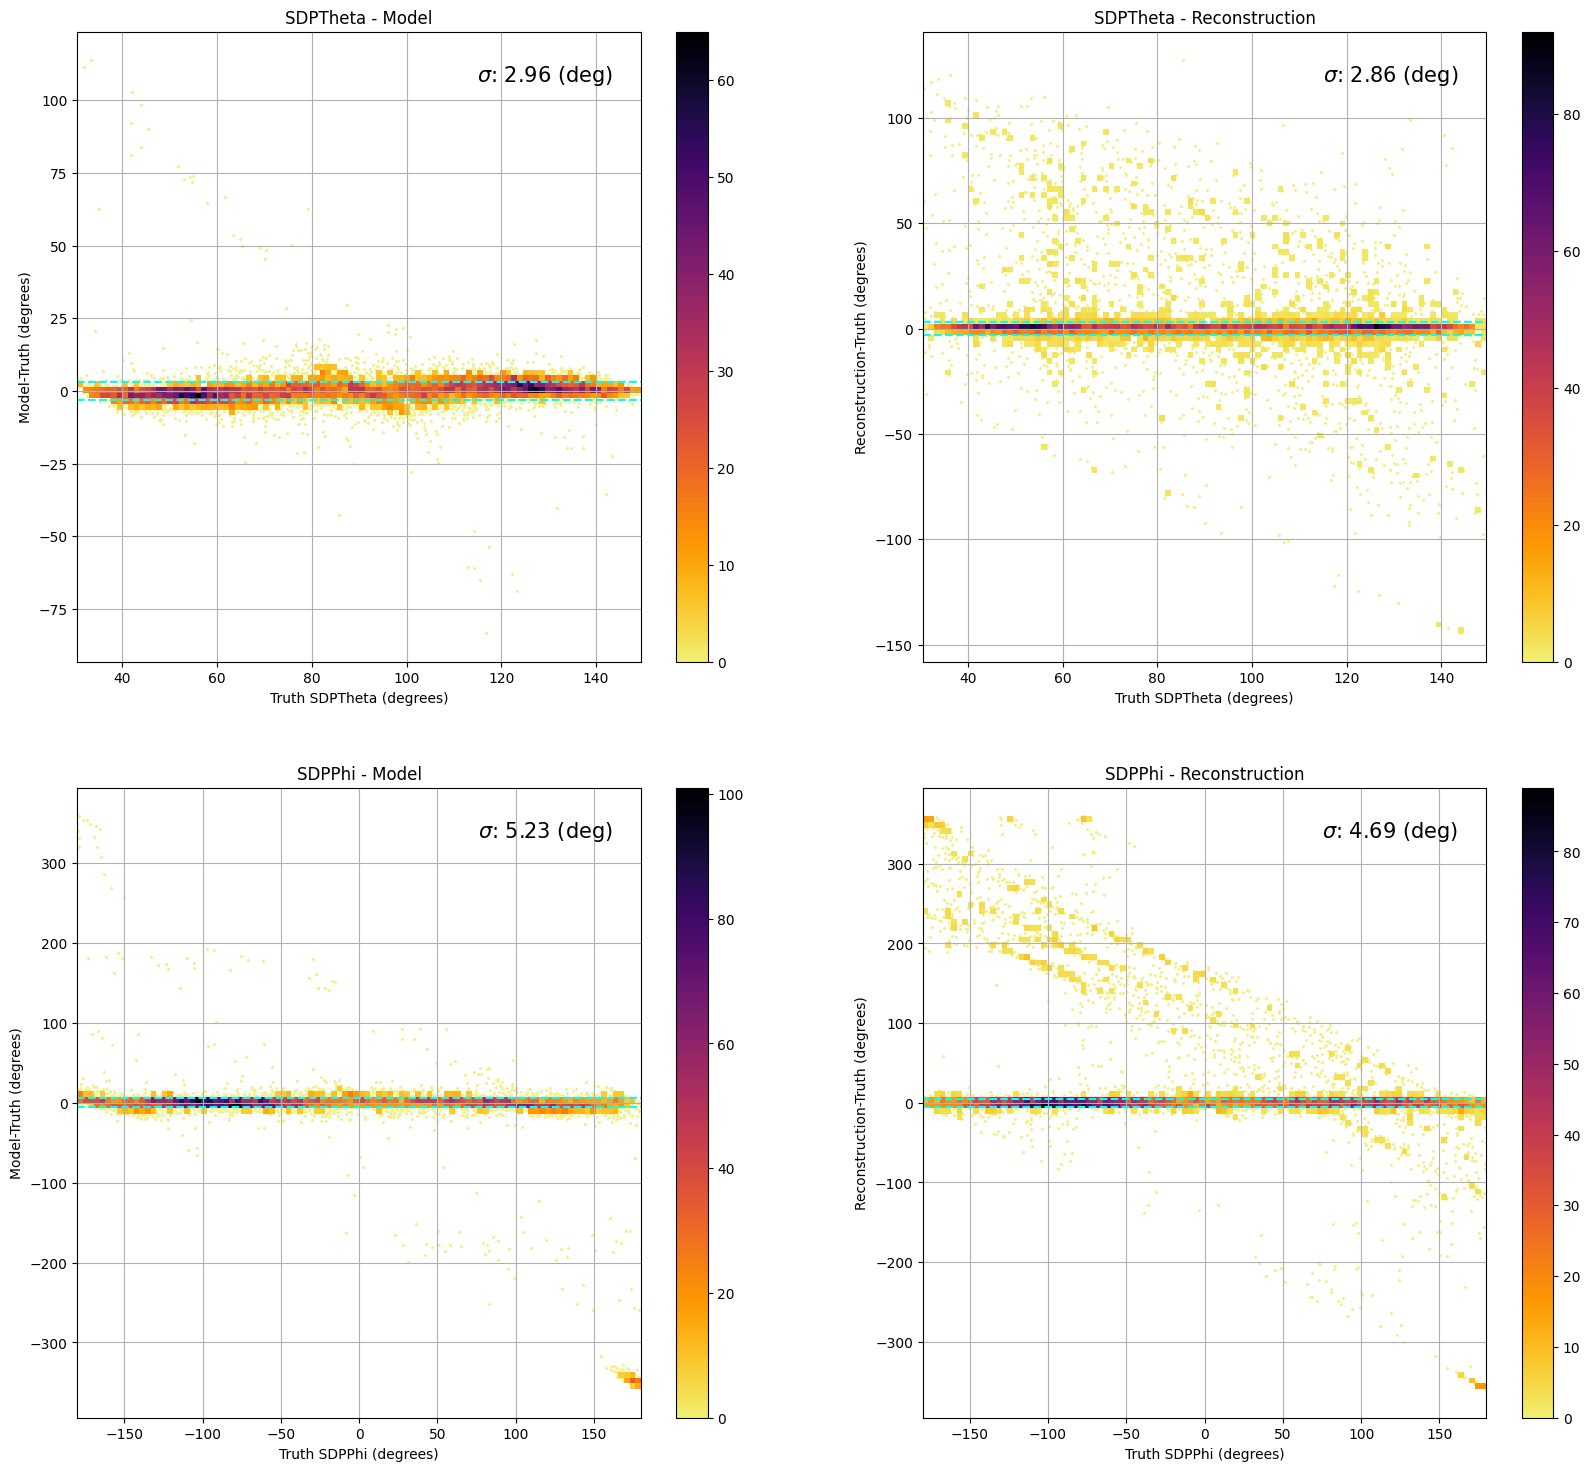

In [29]:

    
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

# Truth = np.array(Results_df[[f'True_{key}'      for key in TruthKeys]].values)
# Pred  = np.array(Results_df[[f'Estimated_{key}' for key in TruthKeys]].values)
# Rec   = np.array(Results_df[[f'Rec_{key}'       for key in TruthKeys]].values)

figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

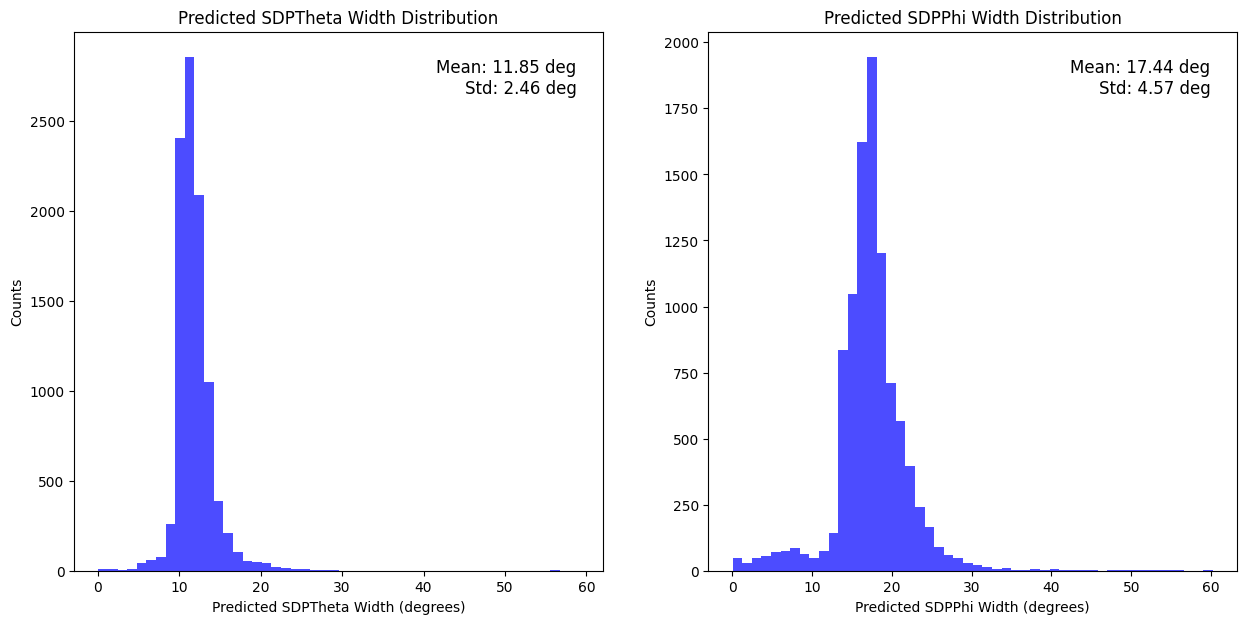

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].hist(np.rad2deg(Pred_Theta_Widths), bins=50, color='blue', alpha=0.7)
ax[0].set_xlabel('Predicted SDPTheta Width (degrees)')
ax[0].set_ylabel('Counts')
ax[0].set_title('Predicted SDPTheta Width Distribution')
ax[0].grid(False)
ax[0].text(0.95, 0.95, f'Mean: {np.rad2deg(np.mean(Pred_Theta_Widths)):.2f} deg\nStd: {np.rad2deg(np.std(Pred_Theta_Widths)):.2f} deg', verticalalignment='top', horizontalalignment='right', transform=ax[0].transAxes, fontsize=12)
ax[1].hist(np.rad2deg(Pred_Phi_Widths), bins=50, color='blue', alpha=0.7)
ax[1].set_xlabel('Predicted SDPPhi Width (degrees)')
ax[1].set_ylabel('Counts')
ax[1].set_title('Predicted SDPPhi Width Distribution')
ax[1].grid(False)
ax[1].text(0.95, 0.95, f'Mean: {np.rad2deg(np.mean(Pred_Phi_Widths)):.2f} deg\nStd: {np.rad2deg(np.std(Pred_Phi_Widths)):.2f} deg', verticalalignment='top', horizontalalignment='right', transform=ax[1].transAxes, fontsize=12)
plt.savefig(f'../Results/UniformSampling_Predicted_Width_Distributions_5xPenalty.png')

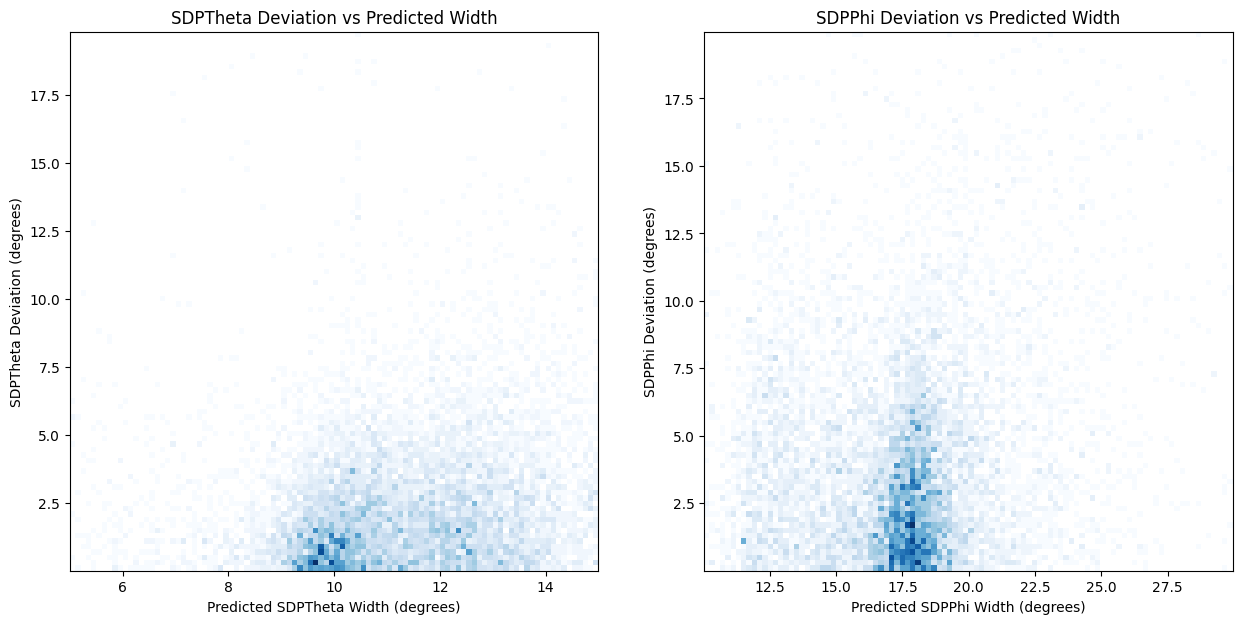

In [ ]:
Theta_Deviations = (np.rad2deg(Pred[:,0] - Truth[:,0]))
Phi_Deviations   = (np.rad2deg(Pred[:,1] - Truth[:,1]))

p_x_lims = (10,30)
p_y_lims = (0,20)
t_x_lims = (5,15)
t_y_lims = (0,20)


# p_x_lims = (0,np.inf)
# p_y_lims = (-np.inf,np.inf)
# t_x_lims = (0,np.inf)
# t_y_lims = (-np.inf,np.inf)

fig, ax = plt.subplots(1,2, figsize=(15,7))

X = np.rad2deg(Pred_Theta_Widths)
Y = np.abs(Theta_Deviations)
Mask = (X>t_x_lims[0]) & (X<t_x_lims[1]) & (Y>t_y_lims[0]) & (Y<t_y_lims[1])
X = X[Mask]
Y = Y[Mask]
# ax[0].scatter(X,Y, s=1, color='blue', alpha=0.7)
ax[0].hist2d(X,Y, bins=100, cmap='Blues', cmin=1)

ax[0].set_xlabel('Predicted SDPTheta Width (degrees)')
ax[0].set_ylabel('SDPTheta Deviation (degrees)')
ax[0].set_title('SDPTheta Deviation vs Predicted Width')
ax[0].grid(False)


X = np.rad2deg(Pred_Phi_Widths)
Y = np.abs(Phi_Deviations)
Mask = (X>p_x_lims[0]) & (X<p_x_lims[1]) & (Y>p_y_lims[0]) & (Y<p_y_lims[1])
X = X[Mask]
Y = Y[Mask]
# ax[1].scatter(X,Y, s=1, color='blue', alpha=0.7)
ax[1].hist2d(X,Y, bins=100, cmap='Blues', cmin=1)
ax[1].set_xlabel('Predicted SDPPhi Width (degrees)')
ax[1].set_ylabel('SDPPhi Deviation (degrees)')
ax[1].set_title('SDPPhi Deviation vs Predicted Width')
ax[1].grid(False)


# ax[0].set_ylim(0,20)
# ax[0].set_xlim(5,15)

# ax[1].set_ylim(0,20)
# ax[1].set_xlim(10,30)